In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import clear_output
from tqdm.notebook import tqdm

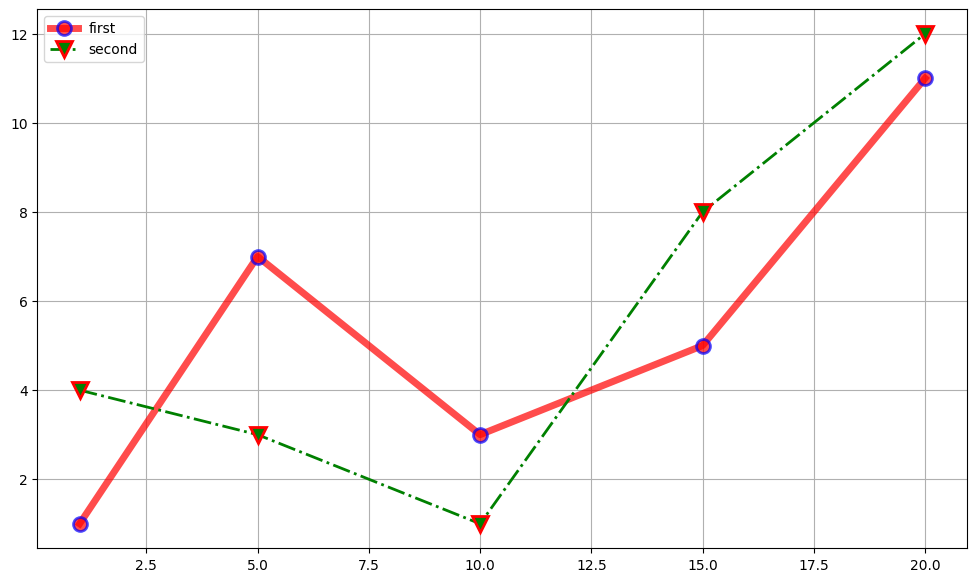

In [2]:
x = [1, 5, 10, 15, 20]
y1 = [1, 7, 3, 5, 11]
y2 = [4, 3, 1, 8, 12]
plt.figure(figsize=(12, 7))
plt.plot(x, y1, 'o-r', alpha=0.7, label="first", lw=5, mec='b', mew=2, ms=10)
plt.plot(x, y2, 'v-.g', label="second", mec='r', lw=2, mew=2, ms=12)
plt.legend()
plt.grid(True)

In [3]:
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

import pandas as pd
import torch
from torch import nn
from torchvision.io import read_image
from torchvision.transforms import v2
from torchvision.models import MobileNet_V2_Weights, mobilenet_v2
from torchvision.models import EfficientNet_V2_S_Weights, efficientnet_v2_s
from torchvision.models import EfficientNet_V2_M_Weights, efficientnet_v2_m
from safetensors.torch import load_model
import numpy as np
import shutil
from collections import defaultdict
from functools import partial
from itertools import chain
import sqlite3
import os
import json
import typing
from typing import Optional
from pathlib import Path
from datetime import datetime
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, classification_report, confusion_matrix
from collections import defaultdict
from accelerate import Accelerator
from PIL import Image

C:\Users\sofi\AppData\Roaming\Python\Python39\site-packages\transformers\utils\generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
C:\Users\sofi\AppData\Roaming\Python\Python39\site-packages\transformers\utils\generic.py:309: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


In [4]:
# фиксации параметров в рамках всего запуска
def seed_everything(seed: int) -> None:
    import os
    import random
    import torch
    import numpy as np

    os.environ["PYTHONHASHSEED"] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)


def seed_worker(worker_id):
    import random
    import numpy as np
    import torch
    
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

SEED = 13
seed_everything(SEED)

import torch
g = torch.Generator()
g.manual_seed(0)

# accelerator = Accelerator(mixed_precision="no", cpu=True)
accelerator = Accelerator(mixed_precision="no")

device = accelerator.device
print(device)

cuda


In [5]:
def visualise_pics(dataset, indexes):
    items = [dataset[index] for index in indexes]
    figure, ax = plt.subplots(nrows=2, ncols=4, figsize=(12, 6))
    for i, item in enumerate(items):
        ax.ravel()[i].imshow(item['img'].numpy().transpose([1, 2, 0]))
        ax.ravel()[i].set_axis_off()
    plt.show()

def visualise_1pic(img: torch.Tensor) -> None:
    plt.imshow(torch.einsum("chw->hwc", img))
    plt.plot()

In [6]:
def get_target(data_dir: Path,
               le: typing.Optional[LabelEncoder] = None,
               label_encoder_pickle_file: Path = Path.cwd() / "data" / "labelencoder.pkl",
               feedbacks : bool = True,
               level : int = 1,
               category1: str = None,
               category2: str = None,
               category3: str = None,
               category4: str = None,
               ):

    folders = os.listdir(data_dir)
    
    if level not in range(1,6):
        raise ValueError("The value of 'level' must be 1, 2, 3, 4 or 5")
    
    if level == 1:
        categories = folders

    elif level == 2:
        if category1 is None:
            raise TypeError("choose_category() missing 1 required positional argument: 'category1'")
        categories = [category for category in folders if category.split("_")[0]==category1]

    elif level == 3:
        if category1 is None or category2 is None:
            raise TypeError("choose_category() missing required positional argument: 'category1' or 'category2'")
        categories = [category for category in folders if (category.split("_")[0]==category1) and (category.split("_")[1]==category2)]

    elif level == 4:
        if category1 is None or category2 is None or category3 is None:
            raise TypeError("choose_category() missing required positional argument: 'category1', 'category2' or 'category3'")
        categories = [category for category in folders if (category.split("_")[0]==category1) and (category.split("_")[1]==category2) and (category.split("_")[2]==category3)]

    elif level == 5:
        if category1 is None or category2 is None or category3 is None  or category4 is None:
            raise TypeError("choose_category() missing required positional argument: 'category1', 'category2', 'category3' or 'category4'")
        categories = [category for category in folders if (category.split("_")[0]==category1) and (category.split("_")[1]==category2) and (category.split("_")[2]==category3) and (category.split("_")[3]==category4)]
    
    if feedbacks:
        paths_card = [data_dir / category / "card" for category in categories]
        paths_feedbacks = [data_dir / category / "feedbacks" for category in categories]
        img_paths = [sorted(sub_category.rglob("*.png")) for sub_category in paths_card + paths_feedbacks]
        img_paths = list(chain(*img_paths))
    else:
        paths_card = [data_dir / category / "card" for category in categories]
        img_paths = [sorted(sub_category.rglob("*.png")) for sub_category in paths_card]
        img_paths = list(chain(*img_paths))
    
    target = ["_".join(path.parts[-3:-2][0].split("_")[:level]) for path in img_paths]
    if level != 1:
        model_name = "_".join(target[0].split("_")[:level-1])
    else:
        model_name = "full_model"
    
    if not le:
        le = LabelEncoder()
        le = le.fit(target)

        # пока убрали сохранение
#         label_encoder_pickle_file.unlink(missing_ok=True)

#         with open(label_encoder_pickle_file, 'wb') as handle:
#             pickle.dump(le, handle, protocol=pickle.HIGHEST_PROTOCOL)

    target_enc = le.transform(target)

    # Соотнесения закодированного таргета и названий категорий
    dict_topic = dict(zip(target, target_enc))
    target2idx = dict(sorted(dict_topic.items(), key=lambda item: item[1]))
    idx2target = dict(zip(target_enc, target))
    
    return img_paths, torch.from_numpy(target_enc).long(), target2idx, idx2target, model_name


def get_traintestsplit(img_paths : list[Path],
                       target_enc : list,
                       SEED : int,
                       ):
    
    train_paths, test_paths, ytrain, ytest = train_test_split(img_paths, target_enc,
                                                              test_size=0.2,
                                                              stratify=target_enc,
                                                              random_state=SEED)
    return train_paths, test_paths, ytrain, ytest


def get_class_weights(target_enc):
    amount = pd.DataFrame(target_enc).value_counts()
    recount = 1 / (amount / amount.sum())
    inverse_weights = recount / recount.sum()
    inverse_weights = torch.from_numpy(inverse_weights.sort_index().values.astype(np.float32))
    weights = torch.from_numpy(pd.DataFrame(target_enc).value_counts(normalize=True).sort_index().values.astype(np.float32))
    
    return weights, inverse_weights

In [7]:
class WbDataset(Dataset):
    def __init__(self,
                 img_paths: list[Path],
                 target=None,
                 transform=None):

        self.img_paths = img_paths
        self.target = target
        self.transform = transform
        
    def __getitem__(self, index):
        img_path = self.img_paths[index]
        #img =  read_image(str(img_path))
        img = Image.open(str(img_path)).convert('RGB')
        
        if self.transform is not None:
            img = self.transform(img)
        if self.target is not None:
            label = self.target[index]
            out = {"img": img, "label": label, "path": str(img_path)}
            return out

        out = {"img": img, "path": str(img_path)}
        return out


    def __len__(self):
        return len(self.img_paths)

# Датасет

In [8]:
data_dir = Path("C:/temp/!hse-mlds-project-year2") / "data_embed"
# data_dir = Path("C:/temp/!hse-mlds-project-year2") / "test"

# processor = MobileNet_V2_Weights.IMAGENET1K_V2.transforms(
#     antialias=True,
# )
processor = EfficientNet_V2_S_Weights.IMAGENET1K_V1.transforms(
    antialias=True,
)
# processor = EfficientNet_V2_M_Weights.IMAGENET1K_V1.transforms(
#     antialias=True,
# )

# в данной функции определяется надо ли исп-ть feedbacks и какие категории брать
img_paths, target_enc, target2idx, idx2target, model_name = get_target(data_dir,
                                                              feedbacks=False,
                                                              level=2,
                                                              category1="Товары&для&взрослых",
                                                              category2="Бумажная&продукция")
train_paths, test_paths, ytrain, ytest = get_traintestsplit(img_paths, target_enc, SEED)

train_dataset = WbDataset(train_paths, ytrain, processor)
test_dataset = WbDataset(test_paths, ytest, processor)
print(len(train_paths), len(test_paths))

211 53


In [9]:
item = train_dataset[0]

print(item.keys())
print(item["img"].shape)                        # чекаем что размеры консистентны
# print(item["label"])
print(item["path"])

dict_keys(['img', 'label', 'path'])
torch.Size([3, 384, 384])
C:\temp\!hse-mlds-project-year2\data_embed\Товары&для&взрослых_Секс&игрушки_Насадки&и&удлинители\card\0.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


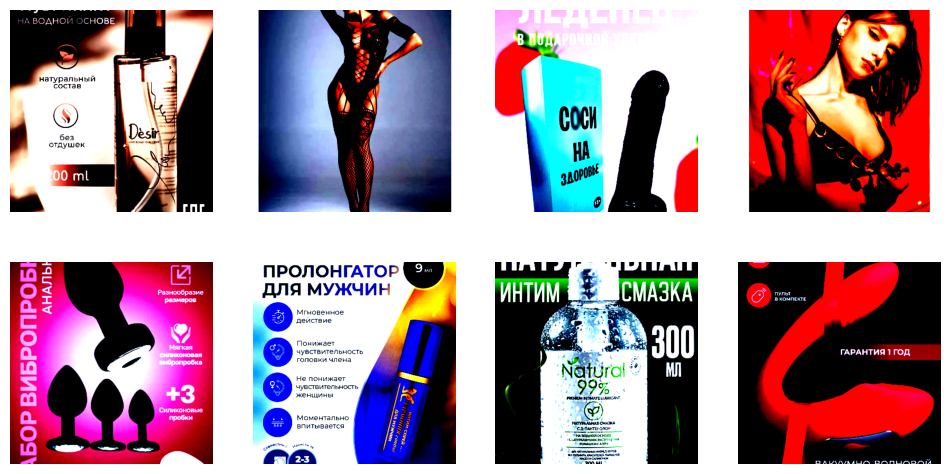

In [10]:
length = len(train_dataset)
indexes = np.random.choice(list(range(length)), size=8, replace=False)

visualise_pics(train_dataset, indexes)

In [11]:
class Collator:
    def __init__(self, transform=None, mixes=None) -> None:
        self.transform = transform
        self.mixes = mixes

    def __call__(self, batch):
        tensor_dict = defaultdict(list)
        for sample in batch:
            for key, value in sample.items():
                tensor_dict[key].append(value)
        
        data = torch.stack(tensor_dict["img"])
        targets = torch.tensor(tensor_dict["label"])

        if self.mixes is not None:
            data, target = self.mixes(data, targets)
        if self.transform is not None:
            data = self.transform(data)
        
        out = {
            "img": data,
            "label": targets,
            "path": tensor_dict["path"],
        }

        return out

In [12]:
#dataset = torch.utils.data.Subset(dataset, [i for i in range(100)])
BATCH_SIZE = 64

train_loader = DataLoader(train_dataset,
                                               batch_size=BATCH_SIZE,
                                               shuffle=True,
                                               collate_fn=Collator(),
                                               pin_memory=True,
                                               generator=torch.Generator().manual_seed(SEED),
                                               worker_init_fn=seed_worker)

val_loader = DataLoader(test_dataset,
                                             batch_size=BATCH_SIZE,
                                             shuffle=False,
                                             collate_fn=Collator(),
                                             pin_memory=True,
                                             generator=torch.Generator().manual_seed(SEED),
                                             worker_init_fn=seed_worker)

In [13]:
# elem = next(iter(train_loader))
# elem[0].shape

# visualise_1pic(elem[0][0])

In [14]:
# pretrain_model = mobilenet_v2(weights=MobileNet_V2_Weights.IMAGENET1K_V2)
pretrain_model = efficientnet_v2_s(weights=EfficientNet_V2_S_Weights.IMAGENET1K_V1)
# pretrain_model = efficientnet_v2_m(weights=EfficientNet_V2_M_Weights.IMAGENET1K_V1)

In [15]:
class Model(torch.nn.Module):
    def __init__(
        self,
        module_features,
        num_classes: int,
        module_out_size: int = 1280,
        dropout_prob: float = 0.3,
        embed_size: int = 1024,

    ):
        super().__init__()
        self.module_features = module_features
        self.module_avgpool = torch.nn.AdaptiveAvgPool2d(output_size=1)
        self.embed = torch.nn.Sequential(
#             torch.nn.Dropout(p=dropout_prob),
            torch.nn.Linear(in_features=module_out_size, out_features=embed_size),
        )
        self.classification = torch.nn.Sequential(
            torch.nn.Tanh(),
            torch.nn.Dropout(p=dropout_prob),
            torch.nn.Linear(in_features=embed_size, out_features=num_classes),
        ) 
        
    def forward(self, inputs):
        step_1 = self.module_features(inputs)
        step_2 = self.module_avgpool(step_1)
        
        # эмбединги для RNN
        embeddings = self.embed(torch.flatten(step_2, 1))

        # классификация
        logits = self.classification(embeddings)

        return logits, embeddings

In [16]:
# device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
# device #= 'cpu'

In [17]:
NUM_CLASSES=len(idx2target)
idx2target

{0: 'Товары&для&взрослых_Белье&и&аксессуары',
 1: 'Товары&для&взрослых_Игры&и&сувениры',
 2: 'Товары&для&взрослых_Интимная&косметика',
 3: 'Товары&для&взрослых_Презервативы&и&лубриканты',
 4: 'Товары&для&взрослых_Секс&игрушки',
 5: 'Товары&для&взрослых_Фетиш&и&БДСМ'}

In [18]:
# Учим только последний слой
for param in pretrain_model.parameters():
       param.requires_grad = False
#        param.requires_grad = True

model = Model(
    module_features=pretrain_model.features,
    num_classes=NUM_CLASSES,
)

sum(param.numel() for param in model.parameters())

21495382

In [19]:
model_name

'Товары&для&взрослых'

In [20]:
pd.DataFrame(target_enc).value_counts().sort_index()

0     20
1     20
2     20
3     24
4    160
5     20
dtype: int64

# Prediction  

## Предсказание по одной модели

In [43]:
from sklearn.metrics import roc_curve, roc_auc_score, auc
from torch.nn.functional import softmax
from sklearn.metrics import average_precision_score, precision_recall_curve
from sklearn.metrics import PrecisionRecallDisplay, RocCurveDisplay

In [22]:
@torch.no_grad()
def inference(model, loader, device):
    model.eval()
    y_preds = []
    probs_check = False
    for batch in tqdm(loader):
        data = batch["img"].to(device)
        logits, _ = model(data)
        y_pred = np.argmax(logits.detach().cpu().numpy(), axis=-1)
        prob = softmax(logits, dim=-1)
        
        if not probs_check:
            probs = torch.cat([prob], dim=0)
            probs_check=True
        else:
            probs = torch.cat([probs, prob], dim=0)       
        
        y_preds.extend(y_pred)
    
    return y_preds, probs.detach().cpu().numpy()

In [23]:
dataset_test = WbDataset(test_paths, None, processor)
#dataset_test = WbDataset(train_paths, None, processor)
#dataset_test = WbDataset(test_paths[:8], ytest, processor)

test_loader = DataLoader(dataset_test,
                                                         batch_size=BATCH_SIZE,
                                                         shuffle=False,
                                                         pin_memory=True,
                                                         generator=torch.Generator().manual_seed(SEED),
                                                         worker_init_fn=seed_worker)

len(dataset_test)

53

In [24]:
model_path = Path.cwd() / "models_categories" / "models_efficientnetv2_s" / model_name
if (model_path / "model.safetensors").exists():
    load_model(model, model_path / "model.safetensors")
else:
    print(model.load_state_dict(torch.load(model_path / "pytorch_model.bin", map_location=torch.device('cpu'))))

model = model.to(device)

<All keys matched successfully>


In [25]:
y_preds, probs = inference(model, test_loader, device)
#y_preds

  0%|          | 0/1 [00:00<?, ?it/s]

In [26]:
def calculate_metrics_by_class(probs : np.array,
                               y_true,  
                               class_ind : int ,
                               threshold : float = 0.5,
                               zero_division = 0):
    true_positives = (probs[:, class_ind] > threshold) & (np.where(y_true == class_ind, True, False))

#     uprecision = np.sum(true_positives) / np.sum(probs[:, class_ind] > threshold)
#     urecall = np.sum(true_positives) / np.sum(np.where(y_true == class_ind, True, False))
#     uf1 = 2*precision*recall / (precision + recall)

    if np.sum(probs[:, class_ind] > threshold) == 0:
        uprecision = np.float64(0.0)
    else:
        uprecision = np.sum(true_positives) / np.sum(probs[:, class_ind] > threshold)

    if np.sum(np.where(y_true == class_ind, True, False)) == 0:
        urecall = np.float64(0.0)
    else:
        urecall = np.sum(true_positives) / np.sum(np.where(y_true == class_ind, True, False))
    
    if (uprecision == 0) and (urecall == 0):
        uf1 = np.float64(0.0)
    else:
        uf1 = 2*uprecision*urecall / (uprecision + urecall)
    
#     print("presicion", uprecision)
#     print("recall", urecall)
#     print("f1", uf1)
    return uprecision, urecall, uf1

In [27]:
#uprecision, urecall, uf1 = calculate_metrics_by_class(probs, ytest, class_ind=3, threshold=0.4)

### PR-curve

In [28]:
def binary_clf_curve_for_thresholds(probs : np.array,
                                    y_true,  
                                    class_ind : int,
                                    thresholds):
    cols = ["tps", "fps", "fns", "tns"]
    metrics = {col: [] for col in cols}
    
    for th in thresholds:
        tp = (probs[:, class_ind] > th) & (np.where(y_true == class_ind, True, False))
        fp = np.sum(probs[:, class_ind] > th) - np.sum(tp)
        fn = np.sum(np.where(y_true == class_ind, True, False)) - np.sum(tp)
        tn = (probs[:, class_ind] <= th) & (np.where(y_true != class_ind, True, False))

        metrics["tps"].append(np.sum(tp))
        metrics["fps"].append(fp)
        metrics["fns"].append(fn)
        metrics["tns"].append(np.sum(tn))
  
    return metrics


def calculate_precision_recall_curve_micro(y_true, probs, idx2target, thresholds, for_all_models=False):
    for class_ind in idx2target.keys():
        metrics = binary_clf_curve_for_thresholds(probs, y_true, class_ind, thresholds)
        
        if class_ind == 0:
            tps = np.array(metrics["tps"])
            fps = np.array(metrics["fps"])
            fns = np.array(metrics["fns"])
            tns = np.array(metrics["tns"])
        else:
            tps = np.vstack((tps, metrics["tps"]))
            fps = np.vstack((fps, metrics["fps"]))
            fns = np.vstack((fns, metrics["fns"]))
            tns = np.vstack((tns, metrics["tns"]))
        
    if for_all_models:
        return tps, fps, fns, tns

    tps_mean = np.mean(tps, axis=0)
    fps_mean = np.mean(fps, axis=0)
    fns_mean = np.mean(fns, axis=0)

    precisions = tps_mean / (tps_mean + fps_mean)
    recalls = tps_mean / (tps_mean + fns_mean)
    
    precisions[-1] = 1.0 #np.float64(0.0)

    return precisions, recalls


def calculate_precision_recall_curve_macro(y_true, probs, idx2target, thresholds):
    precision = defaultdict(list)
    recall = defaultdict(list)

    for th in thresholds:
        for i in idx2target.keys():
            pr, rec, _ = calculate_metrics_by_class(probs, y_true, class_ind=i, threshold=th)
            precision[i].append(pr)
            recall[i].append(rec)
    
    arr = False
    for key in precision.keys():
        if not arr:
            precisions = np.array(precision[key])
            recalls = np.array(recall[key])
            arr = True
        else:
            precisions = np.vstack((precisions, precision[key]))
            recalls = np.vstack((recalls, recall[key]))
    
    precisions[:, -1] = 1.0
    return np.mean(precisions, axis=0), np.mean(recalls, axis=0)

In [29]:
def draw_prcurve_classification(categories : list[str],
                                data_dir : Path,
                                models_path : Path,
                                pretrain_model,
                                processor,
                                device,
                                BATCH_SIZE : int,
                                SEED : int):
    
    cl_results = defaultdict()
    
    for cat1 in categories:
        img_paths, target_enc, target2idx, idx2target, model_name = get_target(data_dir,
                                                                  feedbacks=False,
                                                                  level=2,
                                                                  category1=cat1)
        train_paths, test_paths, ytrain, ytest = get_traintestsplit(img_paths, target_enc, SEED)

        dataset_test = WbDataset(test_paths, None, processor)
        test_loader = DataLoader(dataset_test,
                                batch_size=BATCH_SIZE,
                                shuffle=False,
                                pin_memory=True,
                                generator=torch.Generator().manual_seed(SEED),
                                worker_init_fn=seed_worker)

        for param in pretrain_model.parameters():
            param.requires_grad = False
        NUM_CLASSES=len(idx2target)
        model = Model(
            module_features=pretrain_model.features,
            num_classes=NUM_CLASSES,
        )
        model = model.to(device)
        
        model_path = models_path / model_name
        if (model_path / "model.safetensors").exists():
            load_model(model, model_path / "model.safetensors")
        else:
            model.load_state_dict(torch.load(model_path / "pytorch_model.bin", map_location=torch.device('cpu')))

        y_preds, probs = inference(model, test_loader, device)

        cl_results[model_name] = {"y_true": ytest,"y_preds" : y_preds, "probs" : probs, "idx2target" : idx2target}
        
    #--------------------------------------------------------------------------------------    
    cols = ["macro-macro", "micro-macro"]
    precision = {col: {} for col in cols}
    recall = {col: {} for col in cols}
    average_precision = {col: {} for col in cols}
    tp, fp, fn = defaultdict(), defaultdict(), defaultdict()
    
    arr = False
    for key in cl_results.keys():
        if not arr:
            probs_all = np.array(cl_results[key]["probs"])
            arr = True
        else:
            probs_all = np.append(probs_all, cl_results[key]["probs"])
    
    thresholds = np.insert(np.unique(probs_all), 0, 0)   
    
    
    for key in tqdm(cl_results.keys(), desc=f"Categories"):
        precision["macro-macro"][key], recall["macro-macro"][key] = calculate_precision_recall_curve_macro(
                                                                                cl_results[key]["y_true"],
                                                                                cl_results[key]["probs"],
                                                                                cl_results[key]["idx2target"],
                                                                                thresholds=thresholds,
        )
        average_precision["macro-macro"][key] = average_precision_score(cl_results[key]["y_true"],
                                                                        cl_results[key]["probs"],
                                                                        average="macro")
        
        tp[key], fp[key], fn[key], _ = calculate_precision_recall_curve_micro(cl_results[key]["y_true"],
                                                                              cl_results[key]["probs"],
                                                                              cl_results[key]["idx2target"],
                                                                              thresholds=thresholds,
                                                                              for_all_models=True)
        
        precision["micro-macro"][key], recall["micro-macro"][key] = calculate_precision_recall_curve_micro(
                                                                           cl_results[key]["y_true"],
                                                                           cl_results[key]["probs"],
                                                                           cl_results[key]["idx2target"],
                                                                           thresholds=thresholds,
        )
        average_precision["micro-macro"][key] = average_precision_score(cl_results[key]["y_true"],
                                                                        cl_results[key]["probs"],
                                                                        average="micro")
        

    cols = ["macro-macro", "micro-macro"]
    precisions = {col: [] for col in cols}
    recalls = {col: [] for col in cols}
    average_precisions = {col: [] for col in cols}
    arr = False
    for cat in categories:
        if not arr:
            for key in cols:
                precisions[key] = np.array(precision[key][cat])
                recalls[key] = np.array(recall[key][cat])
                average_precisions[key] = np.array(average_precision[key][cat])
            
            tps = np.array(tp[cat])
            fps = np.array(fp[cat])
            fns = np.array(fn[cat])
            
            arr = True
        else:
            for key in cols:
                precisions[key] = np.vstack((precisions[key], precision[key][cat]))
                recalls[key] = np.vstack((recalls[key], recall[key][cat]))
                average_precisions[key] = np.append(average_precisions[key], average_precision[key][cat])
            
            tps = np.vstack((tps, tp[cat]))
            fps = np.vstack((fps, fp[cat]))
            fns = np.vstack((fns, fn[cat]))

    precision_macro = np.mean(precisions["macro-macro"], axis=0)
    recall_macro = np.mean(recalls["macro-macro"], axis=0)
    average_precision_macro = np.mean(average_precisions["macro-macro"])
    
    tps_mean = np.mean(tps, axis=0)
    fps_mean = np.mean(fps, axis=0)
    fns_mean = np.mean(fns, axis=0)
    precision_micro = tps_mean / (tps_mean + fps_mean)
    recall_micro = tps_mean / (tps_mean + fns_mean)
    precision_micro[-1] = 1.0
    
    precision_micro_macro = np.mean(precisions["micro-macro"], axis=0)
    recall_micro_macro = np.mean(recalls["micro-macro"], axis=0)
    average_precision_micro_macro = np.mean(average_precisions["micro-macro"])
    
    # возможно имеет смысл подобрать цветовую гамму
    _, ax = plt.subplots(figsize=(6, 6))

    f_scores = np.linspace(0.2, 0.8, num=4)
    for f_score in f_scores:
        x = np.linspace(0.01, 1)
        y = f_score * x / (2 * x - f_score)
        (l,) = plt.plot(x[y >= 0], y[y >= 0], color="gray", alpha=0.2)
        plt.annotate("f1={0:0.1f}".format(f_score), xy=(0.9, y[45] + 0.02))

    display = PrecisionRecallDisplay(
            recall=recall_macro,
            precision=precision_macro,
            average_precision=average_precision_macro,
        )
    display.plot(ax=ax, name="Macro-average precision-recall curve", color="gold")
    
    display = PrecisionRecallDisplay(
            recall=recall_micro,
            precision=precision_micro,
            average_precision=average_precision_micro_macro,
        )
    display.plot(ax=ax, name="Micro-average precision-recall curve", color="darkorange")

    display = PrecisionRecallDisplay(
            recall=recall_micro_macro,
            precision=precision_micro_macro,
            average_precision=average_precision_micro_macro,
        )
    display.plot(ax=ax, name="Micro(macro)-average precision-recall curve", color="crimson")

    handles, labels = display.ax_.get_legend_handles_labels()
    handles.extend([l])
    labels.extend(["iso-f1 curves"])   
    ax.legend(handles=handles, labels=labels, bbox_to_anchor=(1.05, 1.0), loc='upper left')
    ax.set_title("Extension of Precision-Recall curve to multi-classificators")
    
    plt.ylim([-0.01, 1.01])
    plt.xlim([-0.01, 1.01])
    plt.show()

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Categories:   0%|          | 0/9 [00:00<?, ?it/s]

C:\temp\ipykernel_8464\168417132.py:44: RuntimeWarning: invalid value encountered in divide
  precisions = tps_mean / (tps_mean + fps_mean)
C:\temp\ipykernel_8464\168417132.py:44: RuntimeWarning: invalid value encountered in divide
  precisions = tps_mean / (tps_mean + fps_mean)
C:\temp\ipykernel_8464\168417132.py:44: RuntimeWarning: invalid value encountered in divide
  precisions = tps_mean / (tps_mean + fps_mean)
C:\temp\ipykernel_8464\168417132.py:44: RuntimeWarning: invalid value encountered in divide
  precisions = tps_mean / (tps_mean + fps_mean)
C:\temp\ipykernel_8464\168417132.py:44: RuntimeWarning: invalid value encountered in divide
  precisions = tps_mean / (tps_mean + fps_mean)
C:\temp\ipykernel_8464\168417132.py:44: RuntimeWarning: invalid value encountered in divide
  precisions = tps_mean / (tps_mean + fps_mean)
C:\temp\ipykernel_8464\168417132.py:44: RuntimeWarning: invalid value encountered in divide
  precisions = tps_mean / (tps_mean + fps_mean)
C:\temp\ipykernel_84

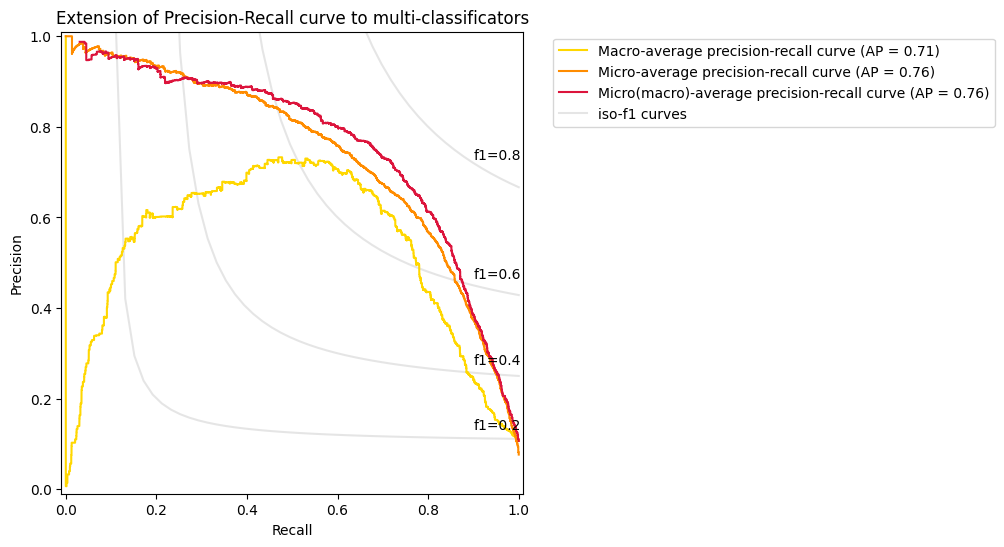

In [30]:
draw_prcurve_classification(#categories=["Здоровье", "Товары&для&взрослых"],
                            categories=["Автотовары",
                                        "Бытовая&техника",
                                        "Детям",
                                        "Здоровье",
                                        "Мебель",
                                        "Обувь",
                                        "Товары&для&взрослых",
                                        "Электроника",
                                        "Ювелирные&изделия"],
                       data_dir=data_dir,
                       models_path=Path.cwd() / "models_categories" / "models_efficientnetv2_s",
                       pretrain_model=pretrain_model,
                       processor=processor,
                       device=device,
                       BATCH_SIZE=BATCH_SIZE,
                       SEED=SEED)

In [31]:
def binary_clf_curve(y_true, probas_pred, class_ind : int):
    desc_score_indices = np.argsort(probas_pred, kind="mergesort")[::-1]
    probas_pred = probas_pred[desc_score_indices]
    distinct_value_indices = np.where(np.diff(probas_pred))[0]
    threshold_idxs = np.r_[distinct_value_indices, len(y_true) - 1]
    
    y_true = np.where(y_true == class_ind, True, False)
    y_true = y_true[desc_score_indices]
    tps = np.cumsum(y_true * 1)[threshold_idxs]
    fps = 1 + threshold_idxs - tps
    
    return fps, tps, probas_pred[threshold_idxs]
    

def calculate_precision_recall_curve(y_true, probs, class_ind : int):
    probas_pred = probs[:, class_ind]
    fps, tps, thresholds = binary_clf_curve(y_true=y_true, probas_pred=probas_pred, class_ind=class_ind)
    
    ps = tps + fps
#     print(tps)
#     print(fps)
#     print(tps[-1] - tps)
    recall = tps / tps[-1]
    precision = np.zeros_like(tps, dtype=np.float64)
    np.divide(tps, ps, out=precision, where=(ps != 0))

    sl = slice(None, None, -1)

    return np.hstack((precision[sl], 1)), np.hstack((recall[sl], 0)), thresholds[sl]

In [32]:
#calculate_precision_recall_curve(ytest, probs, class_ind=3)

In [33]:
def draw_prcurve_formodel(y_true, probs, idx2target, model_name, macro=True, micro=True):
    precision = defaultdict()
    recall = defaultdict()
    average_precision = defaultdict()

    for i in list(idx2target.keys()):
        precision[i], recall[i], _ = precision_recall_curve(y_true, probs[:, i], pos_label=i)
        average_precision[i] = average_precision_score(np.where(y_true==i, True, False) * 1, probs[:, i], pos_label=1)

    # возможно имеет смысл подобрать цветовую гамму
    _, ax = plt.subplots(figsize=(6, 6))

    f_scores = np.linspace(0.2, 0.8, num=4)
    for f_score in f_scores:
        x = np.linspace(0.01, 1)
        y = f_score * x / (2 * x - f_score)
        (l,) = plt.plot(x[y >= 0], y[y >= 0], color="gray", alpha=0.2)
        plt.annotate("f1={0:0.1f}".format(f_score), xy=(0.9, y[45] + 0.02))

    if macro:
        precision["macro"], recall["macro"] = calculate_precision_recall_curve_macro(y_true,
                                                                                        probs,
                                                                                        idx2target,
                                                                                        thresholds=np.insert(np.unique(probs), 0, 0))
        average_precision["macro"] = average_precision_score(y_true, probs, average="macro")

        display = PrecisionRecallDisplay(
            recall=recall["macro"],
            precision=precision["macro"],
            average_precision=average_precision["macro"],
        )
        display.plot(ax=ax, name="Macro-average precision-recall", color="turquoise")
    
    if micro:
        enc = OneHotEncoder()
        y_truebin = enc.fit_transform(y_true.reshape((-1,1)))
        y_truebin = y_truebin.toarray()
        precision["micro"], recall["micro"], _  = precision_recall_curve(y_truebin.ravel(), probs.ravel())
        average_precision["micro"] = average_precision_score(y_true, probs, average="micro")
        
        display = PrecisionRecallDisplay(
            recall=recall["micro"],
            precision=precision["micro"],
            average_precision=average_precision["micro"],
        )
        display.plot(ax=ax, name="Micro-average precision-recall", color="darkorange")

        # newcmap = np.vstack((plt.cm.cool(np.linspace(0,1,3)), plt.cm.viridis(np.linspace(0,1,3))))
#     newcmap = plt.cm.plasma(np.linspace(0, 1, len(idx2target)))
#     print(newcmap)
#     plt.rcParams["axes.prop_cycle"] = plt.cycler("color", newcmap)

#     with plt.rc_context({"axes.prop_cycle" : plt.cycler("color", newcmap)})

    for i in list(idx2target.keys()):
        display = PrecisionRecallDisplay(
            recall=recall[i],
            precision=precision[i],
            average_precision=average_precision[i],
        )
#         display.plot(ax=ax, name=f"Precision-recall for class\n{idx2target[i]}")
        display.plot(ax=ax, name=f"Precision-recall for class {i}")


    handles, labels = display.ax_.get_legend_handles_labels()
    handles.extend([l])
    labels.extend(["iso-f1 curves"])
    # ax.legend(handles=handles, labels=labels, loc="best")
    ax.legend(handles=handles, labels=labels, bbox_to_anchor=(1.05, 1.0), loc='upper left')
    ax.set_title(f'Extension of Precision-Recall curve to model "{model_name}"')

    plt.ylim([-0.01, 1.01])
    plt.xlim([-0.01, 1.01])
    plt.show()

In [34]:
# draw_prcurve_formodel(ytest, probs, idx2target, model_name)

In [35]:
def draw_curve_formodels(curve_type: str,
                           categories : list[str],
                           data_dir : Path,
                           models_path : Path,
                           pretrain_model,
                           processor,
                           device,
                           BATCH_SIZE : int,
                           SEED : int):
    
    curve_type_options = ("pr", "roc")
    if curve_type not in curve_type_options:
        raise ValueError("curve_type has to be one of {0}".format(curve_type_options))    
    
    for cat1 in categories:
        img_paths, target_enc, target2idx, idx2target, model_name = get_target(data_dir,
                                                                  feedbacks=False,
                                                                  level=2,
                                                                  category1=cat1)
        train_paths, test_paths, ytrain, ytest = get_traintestsplit(img_paths, target_enc, SEED)

        dataset_test = WbDataset(test_paths, None, processor)
        test_loader = DataLoader(dataset_test,
                                batch_size=BATCH_SIZE,
                                shuffle=False,
                                pin_memory=True,
                                generator=torch.Generator().manual_seed(SEED),
                                worker_init_fn=seed_worker)

        for param in pretrain_model.parameters():
            param.requires_grad = False
        NUM_CLASSES=len(idx2target)
        model = Model(
            module_features=pretrain_model.features,
            num_classes=NUM_CLASSES,
        )
        model = model.to(device)
        
        model_path = models_path / model_name
        if (model_path / "model.safetensors").exists():
            load_model(model, model_path / "model.safetensors")
        else:
            model.load_state_dict(torch.load(model_path / "pytorch_model.bin", map_location=torch.device('cpu')))

        y_preds, probs = inference(model, test_loader, device)
        
        newcmap = plt.cm.viridis(np.linspace(0, 1, len(idx2target)))
        plt.rcParams["axes.prop_cycle"] = plt.cycler("color", newcmap)

        if curve_type == "pr":
            draw_prcurve_formodel(ytest, probs, idx2target, model_name)
        if curve_type == "roc":
            draw_roccurve_formodel(ytest, probs, idx2target, model_name)

  0%|          | 0/5 [00:00<?, ?it/s]

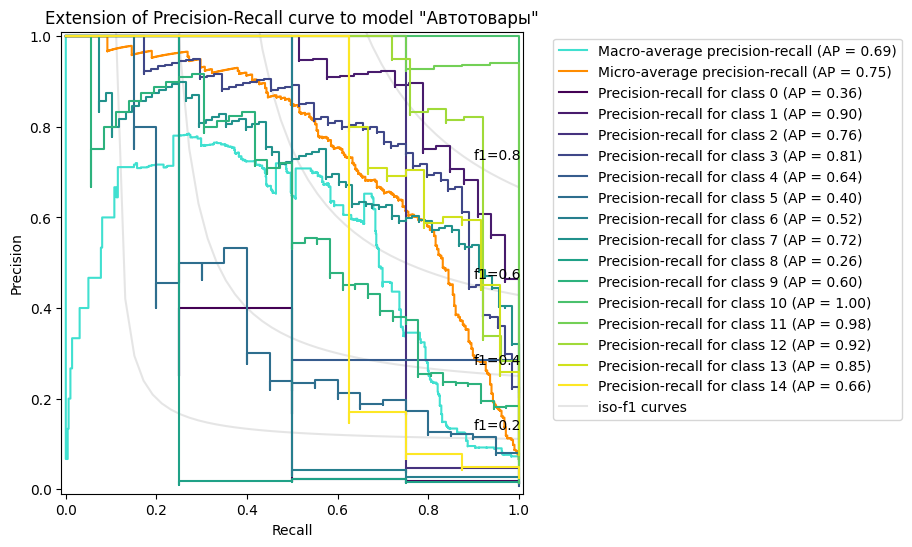

  0%|          | 0/2 [00:00<?, ?it/s]

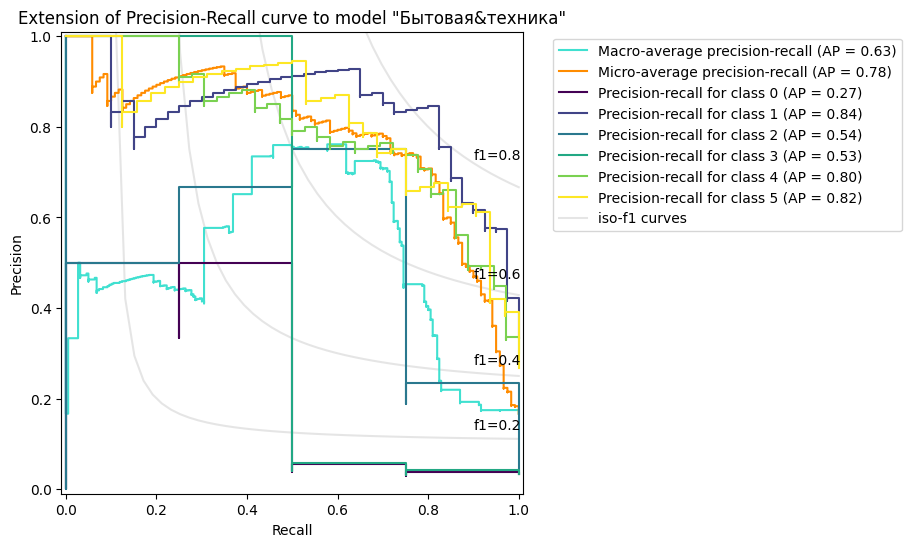

  0%|          | 0/6 [00:00<?, ?it/s]

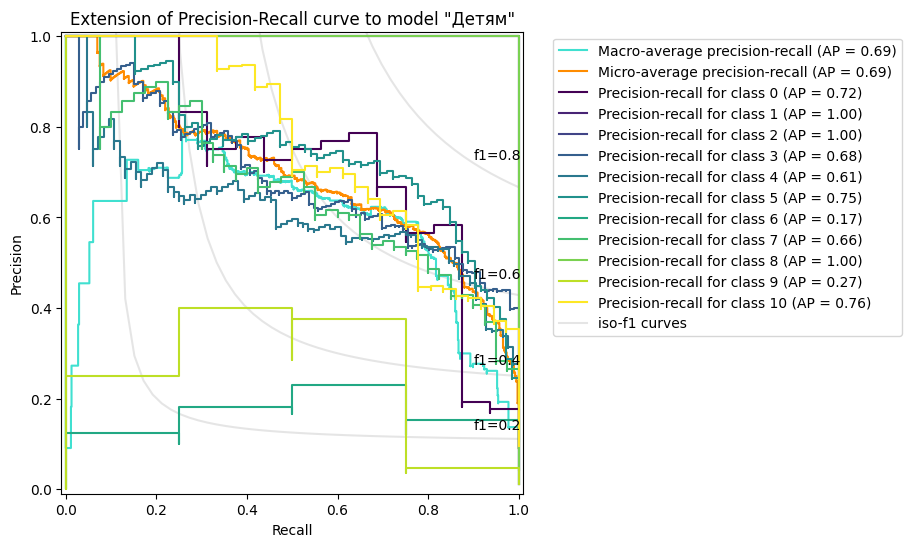

  0%|          | 0/2 [00:00<?, ?it/s]

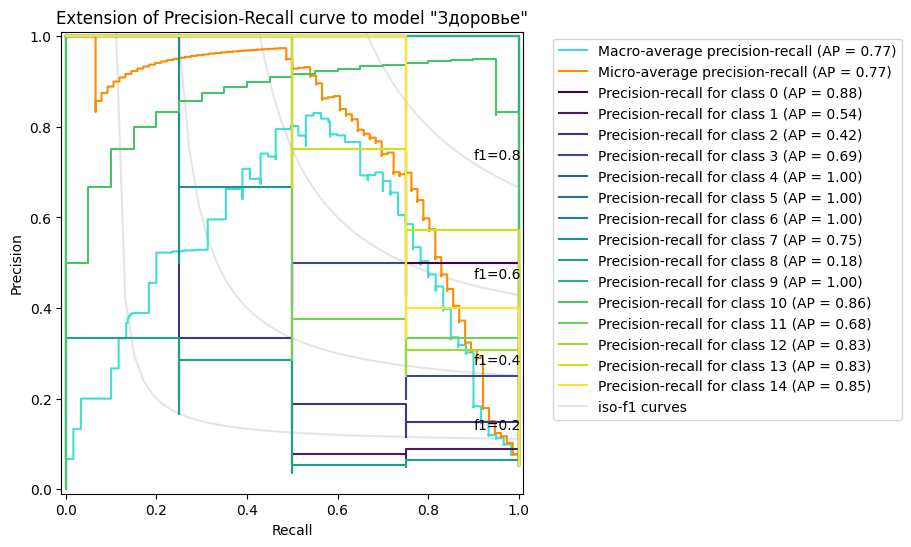

  0%|          | 0/6 [00:00<?, ?it/s]

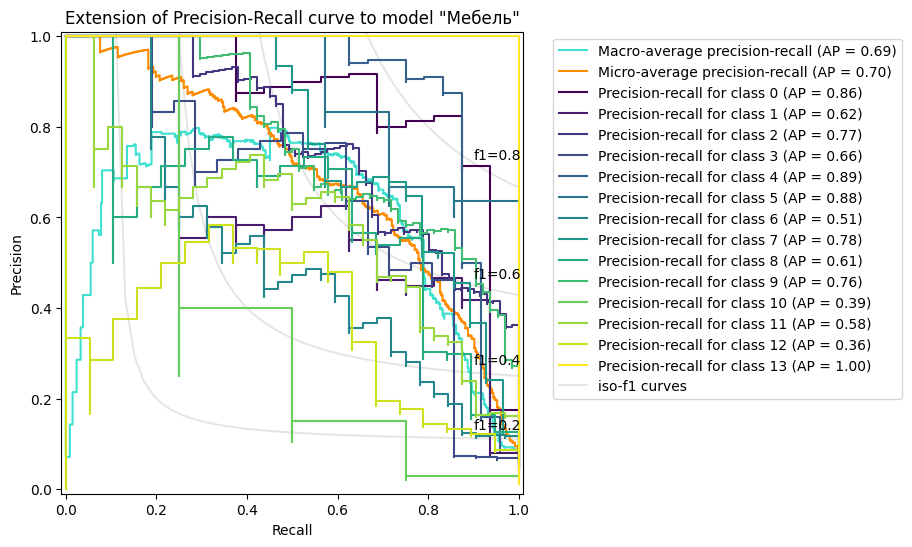

  0%|          | 0/2 [00:00<?, ?it/s]

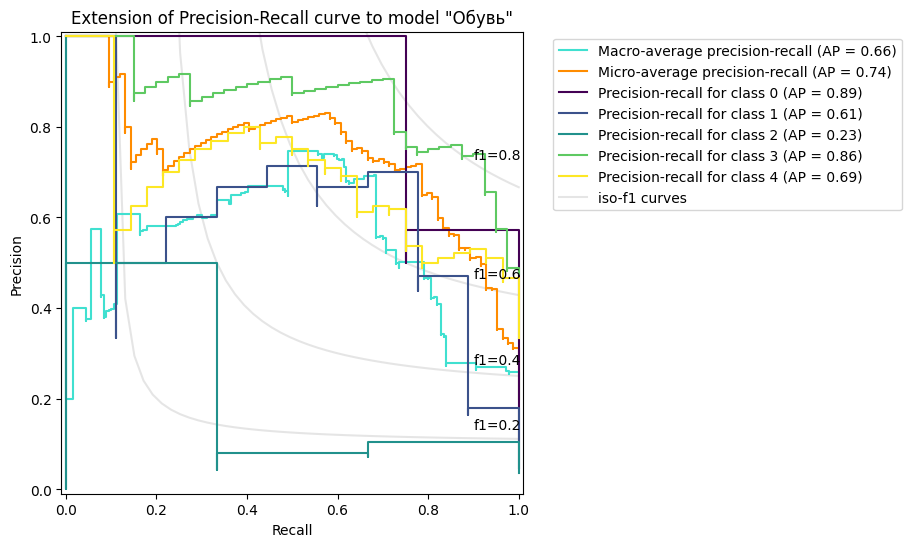

  0%|          | 0/1 [00:00<?, ?it/s]

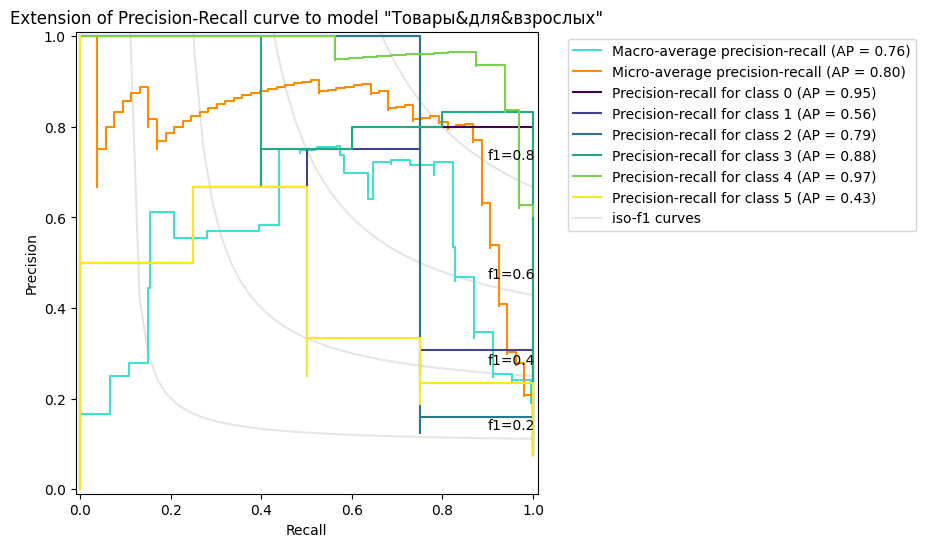

  0%|          | 0/7 [00:00<?, ?it/s]

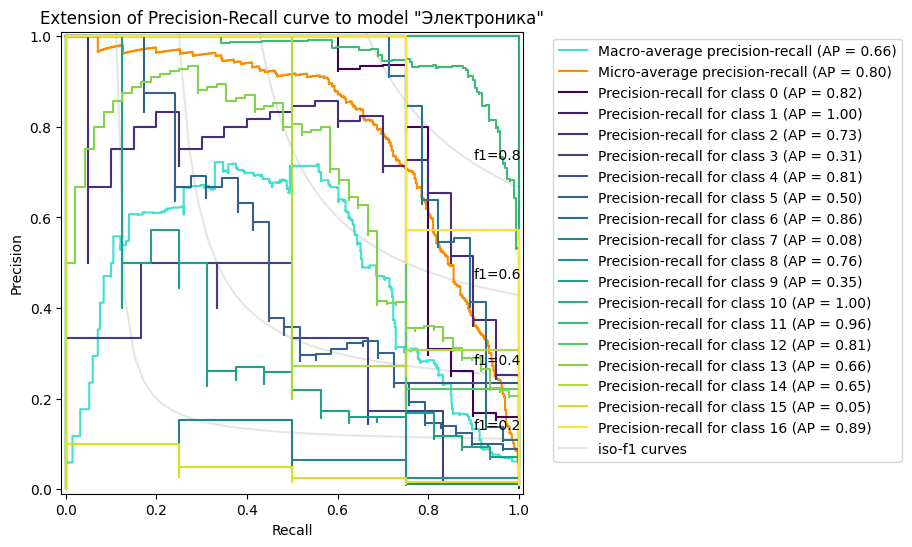

  0%|          | 0/1 [00:00<?, ?it/s]

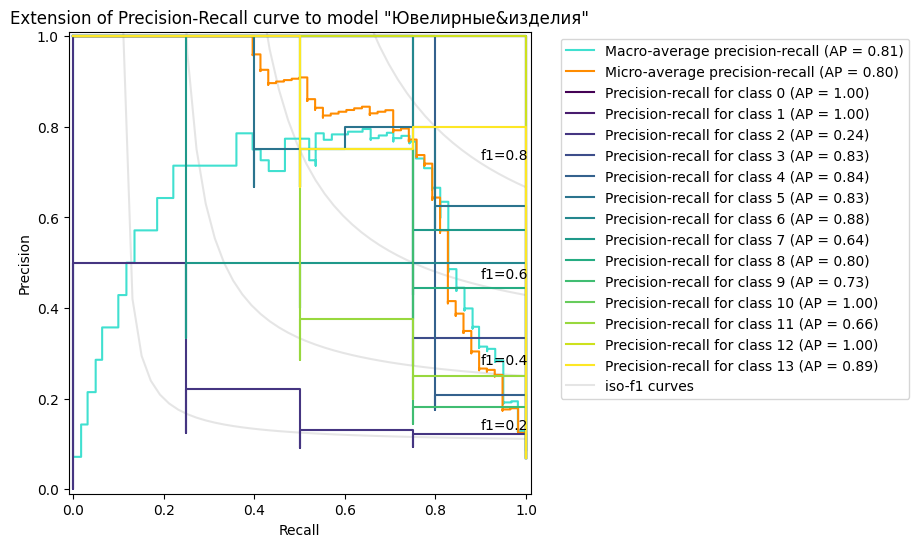

In [37]:
draw_curve_formodels(curve_type="pr",
#                      categories=["Здоровье",
#                                  "Товары&для&взрослых"],
                     categories=["Автотовары",
                                 "Бытовая&техника",
                                 "Детям",
                                 "Здоровье",
                                 "Мебель",
                                 "Обувь",
                                 "Товары&для&взрослых",
                                 "Электроника",
                                 "Ювелирные&изделия"],
                     data_dir=data_dir,
                     models_path=Path.cwd() / "models_categories" / "models_efficientnetv2_s",
                     pretrain_model=pretrain_model,
                     processor=processor,
                     device=device,
                     BATCH_SIZE=BATCH_SIZE,
                     SEED=SEED)

### ROC-curve

In [38]:
def calculate_roc_curve_macro(y_true, probs, idx2target, thresholds):
    for class_ind in idx2target.keys():
        metrics = binary_clf_curve_for_thresholds(probs, y_true, class_ind, thresholds)
        fpr = (np.array(metrics["fps"]) / (np.array(metrics["fps"]) + np.array(metrics["tns"])))[::-1]
        tpr = (np.array(metrics["tps"]) / (np.array(metrics["tps"]) + np.array(metrics["fns"])))[::-1]
        
        if class_ind == 0:
            fprs = fpr
            tprs = tpr
        else:
            fprs = np.vstack((fprs, fpr))
            tprs = np.vstack((tprs, tpr))
            
    fprs_mean = np.mean(fprs, axis=0)
    tprs_mean = np.mean(tprs, axis=0)
    
    return fprs_mean, tprs_mean

In [39]:
def draw_roccurve_formodel(y_true, probs, idx2target, model_name, macro=True, micro=True):
    fpr, tpr, roc_auc = defaultdict(), defaultdict(), defaultdict()
    
    # возможно имеет смысл подобрать цветовую гамму
    _, ax = plt.subplots(figsize=(6, 6))

#     newcmap = np.vstack((plt.cm.cool(np.linspace(0,1,3)), plt.cm.viridis(np.linspace(0,1,3))))
#     newcmap = plt.cm.plasma(np.linspace(0, 1, len(idx2target)))
#     print(newcmap)
#     plt.rcParams["axes.prop_cycle"] = plt.cycler("color", newcmap)
#     with plt.rc_context({"axes.prop_cycle" : plt.cycler("color", newcmap)})

    if macro:
        fpr["macro"], tpr["macro"] = calculate_roc_curve_macro(y_true,
                                                               probs,
                                                               idx2target,
                                                               thresholds=np.insert(np.unique(probs), 0, 0))
        roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

        display = RocCurveDisplay(
            fpr=fpr["macro"],
            tpr=tpr["macro"],
            roc_auc=roc_auc["macro"]
        )
        display.plot(ax=ax, name="Macro-average ROC curve", color="turquoise", linestyle=":", linewidth=4)

    if micro:
        enc = OneHotEncoder()
        y_truebin = enc.fit_transform(y_true.reshape((-1,1)))
        y_truebin = y_truebin.toarray()
        fpr["micro"], tpr["micro"], _  = roc_curve(y_truebin.ravel(), probs.ravel())
        roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
        
        display = RocCurveDisplay(
            fpr=fpr["micro"],
            tpr=tpr["micro"],
            roc_auc=roc_auc["micro"]
        )
        display.plot(ax=ax, name="Micro-average ROC curve", color="deeppink", linestyle=":", linewidth=4)

    for i in list(idx2target.keys()):
        RocCurveDisplay.from_predictions(
            np.where(y_true == i, y_true, -1),
            probs[:, i],
            pos_label=i,
            name=f"ROC curve for class {i}",   #f"Precision-recall for class\n{idx2target[i]}"
            ax=ax,
            plot_chance_level=(i==len(idx2target)-1),
        )

    ax.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
    _ = ax.set(
        xlabel="False Positive Rate",
        ylabel="True Positive Rate",
        title=f'Extension of ROC curve to model "{model_name}"',
    )

    plt.show()

In [40]:
# draw_roccurve_formodel(ytest, probs, idx2target, model_name)

  0%|          | 0/5 [00:00<?, ?it/s]

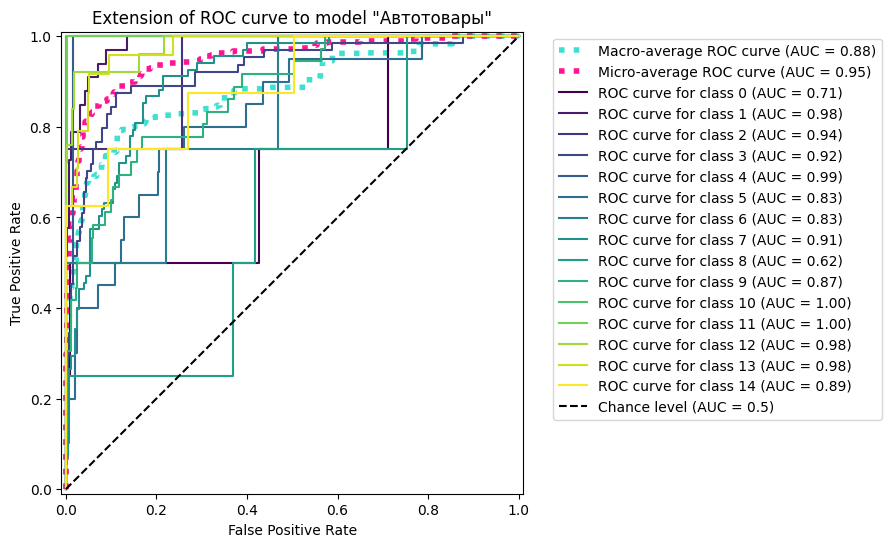

  0%|          | 0/2 [00:00<?, ?it/s]

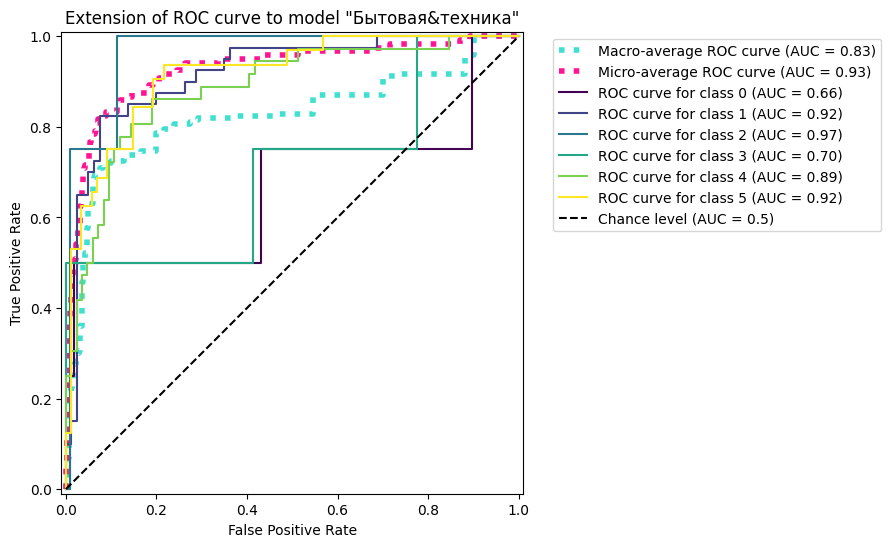

  0%|          | 0/6 [00:00<?, ?it/s]

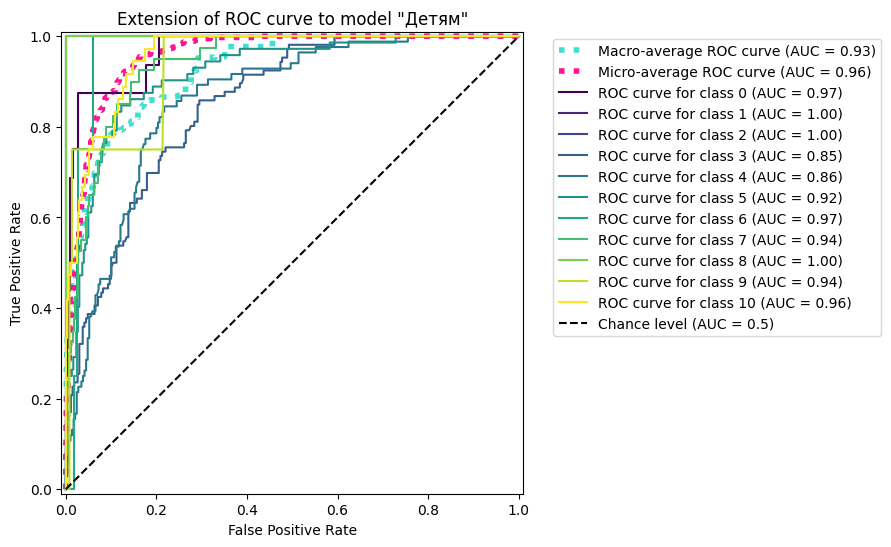

  0%|          | 0/2 [00:00<?, ?it/s]

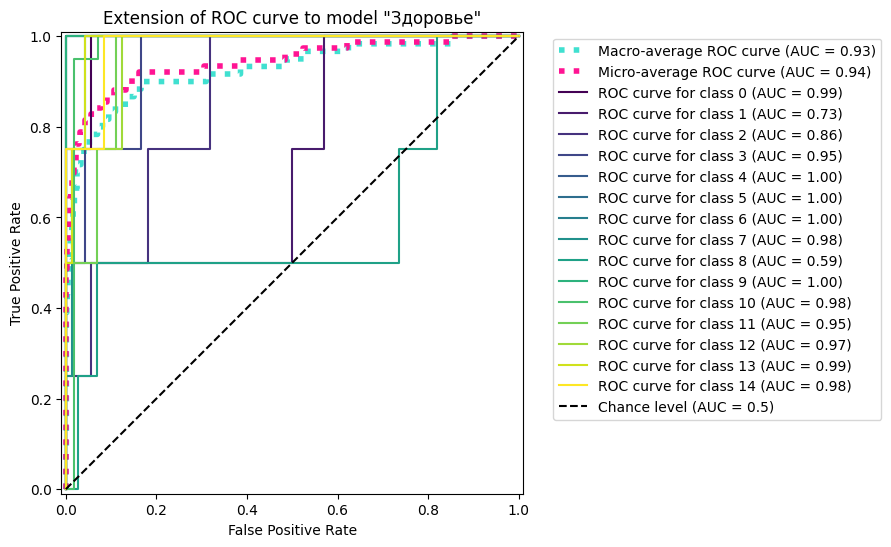

  0%|          | 0/6 [00:00<?, ?it/s]

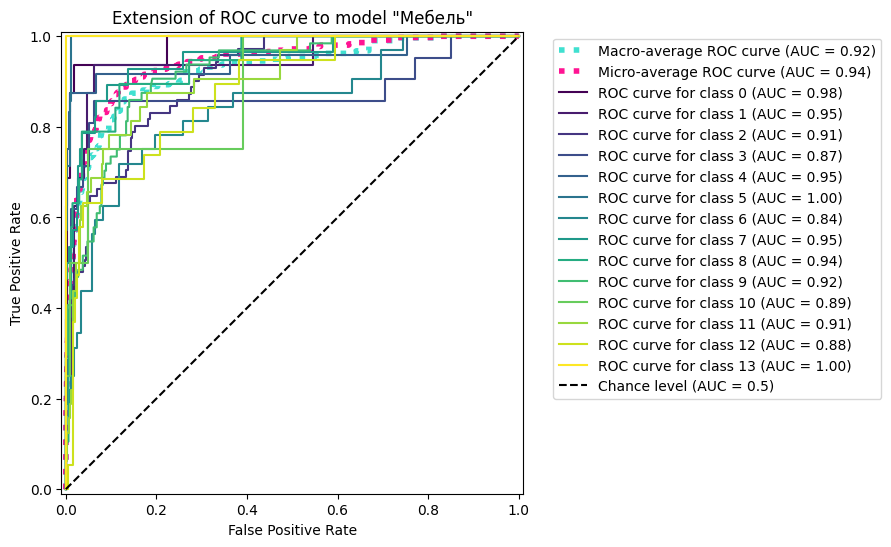

  0%|          | 0/2 [00:00<?, ?it/s]

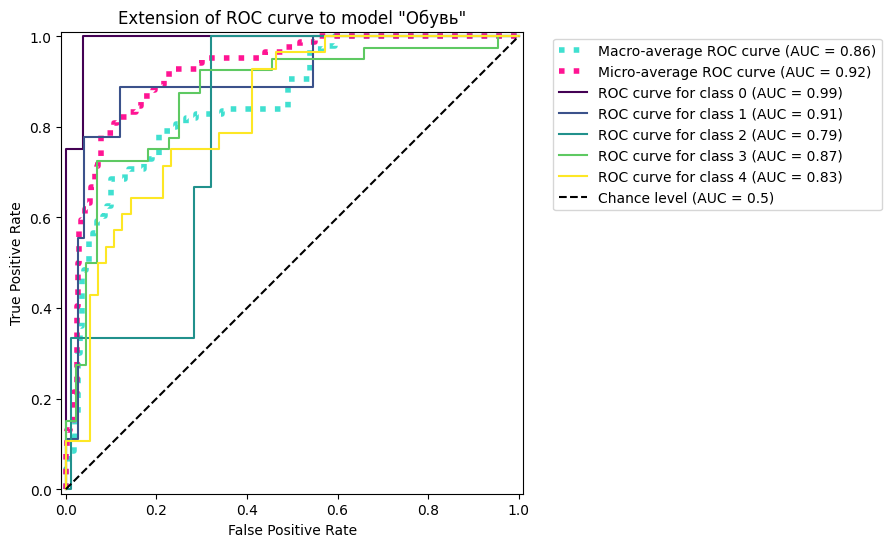

  0%|          | 0/1 [00:00<?, ?it/s]

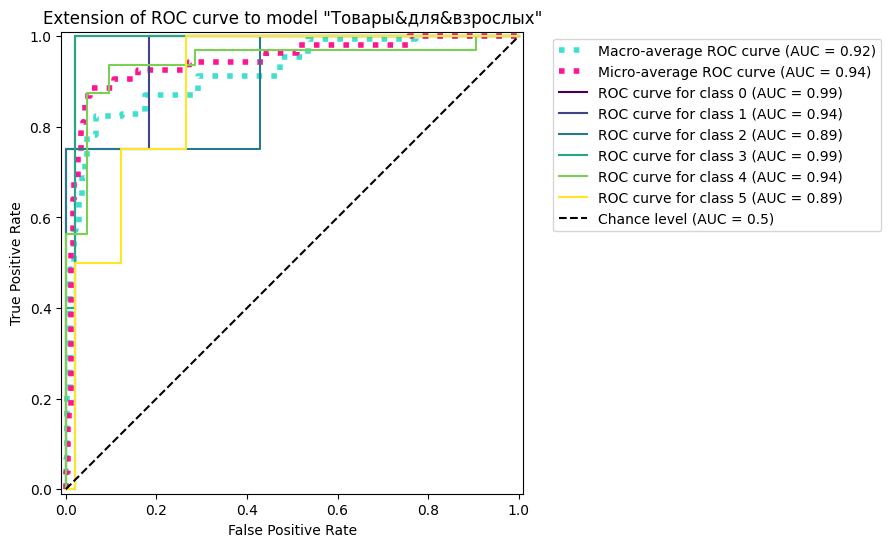

  0%|          | 0/7 [00:00<?, ?it/s]

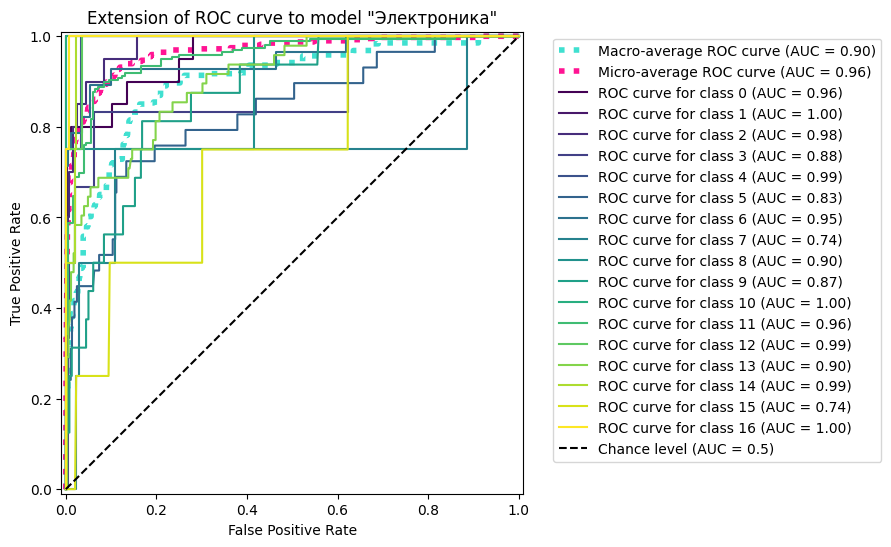

  0%|          | 0/1 [00:00<?, ?it/s]

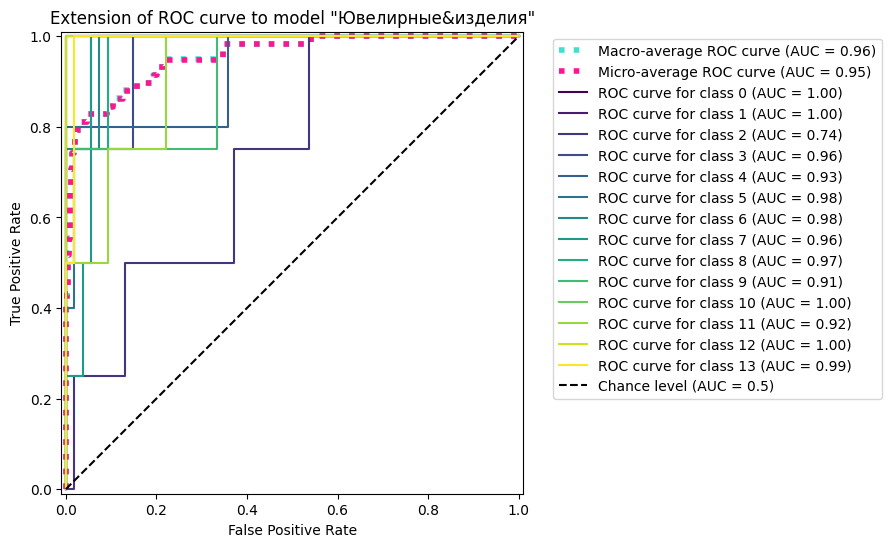

In [44]:
draw_curve_formodels(curve_type="roc",
#                      categories=["Здоровье",
#                                  "Товары&для&взрослых"],
                     categories=["Автотовары",
                                 "Бытовая&техника",
                                 "Детям",
                                 "Здоровье",
                                 "Мебель",
                                 "Обувь",
                                 "Товары&для&взрослых",
                                 "Электроника",
                                 "Ювелирные&изделия"],                     
                     data_dir=data_dir,
                     models_path=Path.cwd() / "models_categories" / "models_efficientnetv2_s",
                     pretrain_model=pretrain_model,
                     processor=processor,
                     device=device,
                     BATCH_SIZE=BATCH_SIZE,
                     SEED=SEED)

In [45]:
def draw_roccurve_classification(categories : list[str],
                                data_dir : Path,
                                models_path : Path,
                                pretrain_model,
                                processor,
                                device,
                                BATCH_SIZE : int,
                                SEED : int):
    
    cl_results = defaultdict()
    
    for cat1 in categories:
        img_paths, target_enc, target2idx, idx2target, model_name = get_target(data_dir,
                                                                  feedbacks=False,
                                                                  level=2,
                                                                  category1=cat1)
        train_paths, test_paths, ytrain, ytest = get_traintestsplit(img_paths, target_enc, SEED)

        dataset_test = WbDataset(test_paths, None, processor)
        test_loader = DataLoader(dataset_test,
                                batch_size=BATCH_SIZE,
                                shuffle=False,
                                pin_memory=True,
                                generator=torch.Generator().manual_seed(SEED),
                                worker_init_fn=seed_worker)

        for param in pretrain_model.parameters():
            param.requires_grad = False
        NUM_CLASSES=len(idx2target)
        model = Model(
            module_features=pretrain_model.features,
            num_classes=NUM_CLASSES,
        )
        model = model.to(device)
        
        model_path = models_path / model_name
        if (model_path / "model.safetensors").exists():
            load_model(model, model_path / "model.safetensors")
        else:
            model.load_state_dict(torch.load(model_path / "pytorch_model.bin", map_location=torch.device('cpu')))

        y_preds, probs = inference(model, test_loader, device)

        cl_results[model_name] = {"y_true": ytest,"y_preds" : y_preds, "probs" : probs, "idx2target" : idx2target}
        
    #--------------------------------------------------------------------------------------    
    cols = ["macro-macro", "micro-macro"]
    fpr = {col: {} for col in cols}
    tpr = {col: {} for col in cols}
    roc_auc = {col: {} for col in cols}
    tp, fp, fn, tn = defaultdict(), defaultdict(), defaultdict(), defaultdict()
    
    arr = False
    for key in cl_results.keys():
        if not arr:
            probs_all = np.array(cl_results[key]["probs"])
            arr = True
        else:
            probs_all = np.append(probs_all, cl_results[key]["probs"])
    
    thresholds = np.insert(np.unique(probs_all), 0, 0)   
    
    
    for key in tqdm(cl_results.keys(), desc=f"Categories"):
        fpr["macro-macro"][key], tpr["macro-macro"][key] = calculate_roc_curve_macro(cl_results[key]["y_true"],
                                                                                     cl_results[key]["probs"],
                                                                                     cl_results[key]["idx2target"],
                                                                                     thresholds=thresholds)
        roc_auc["macro-macro"][key] = auc(fpr["macro-macro"][key], tpr["macro-macro"][key])
        
        tp[key], fp[key], fn[key], tn[key] = calculate_precision_recall_curve_micro(
                                                                           cl_results[key]["y_true"],
                                                                           cl_results[key]["probs"],
                                                                           cl_results[key]["idx2target"],
                                                                           thresholds=thresholds,
                                                                           for_all_models=True
        )
        
        fpr["micro-macro"][key] = np.mean(fp[key], axis=0) / (np.mean(fp[key], axis=0) + np.mean(tn[key], axis=0))
        tpr["micro-macro"][key] = np.mean(tp[key], axis=0) / (np.mean(tp[key], axis=0) + np.mean(fn[key], axis=0))       
        roc_auc["micro-macro"][key] = auc(fpr["micro-macro"][key], tpr["micro-macro"][key])

    cols = ["macro-macro", "micro-macro"]
    fprs = {col: [] for col in cols}
    tprs = {col: [] for col in cols}
    roc_aucs = {col: [] for col in cols}
    arr = False
    for cat in categories:
        if not arr:
            for key in cols:
                fprs[key] = np.array(fpr[key][cat])
                tprs[key] = np.array(tpr[key][cat])
                roc_aucs[key] = np.array(roc_auc[key][cat])
            
            tps = np.array(tp[cat])
            fps = np.array(fp[cat])
            fns = np.array(fn[cat])
            tns = np.array(tn[cat])
            
            arr = True
        else:
            for key in cols:
                fprs[key] = np.vstack((fprs[key], fpr[key][cat]))
                tprs[key] = np.vstack((tprs[key], tpr[key][cat]))
                roc_aucs[key] = np.append(roc_aucs[key], roc_auc[key][cat])
            
            tps = np.vstack((tps, tp[cat]))
            fps = np.vstack((fps, fp[cat]))
            fns = np.vstack((fns, fn[cat]))
            tns = np.vstack((tns, tn[cat]))

    fpr_macro = np.mean(fprs["macro-macro"], axis=0)
    tpr_macro = np.mean(tprs["macro-macro"], axis=0)
    roc_auc_macro = np.mean(roc_aucs["macro-macro"])
    
    tps_mean = np.mean(tps, axis=0)
    fps_mean = np.mean(fps, axis=0)
    fns_mean = np.mean(fns, axis=0)
    tns_mean = np.mean(tns, axis=0)
    fpr_micro = fps_mean / (fps_mean + tns_mean)
    tpr_micro = tps_mean / (tps_mean + fns_mean)
    roc_auc_micro = auc(fpr_micro, tpr_micro)
    
    fpr_micro_macro = np.mean(fprs["micro-macro"], axis=0)
    tpr_micro_macro = np.mean(tprs["micro-macro"], axis=0)
    roc_auc_micro_macro = np.mean(roc_aucs["micro-macro"])
    
    # возможно имеет смысл подобрать цветовую гамму
    _, ax = plt.subplots(figsize=(6, 6))

    display = RocCurveDisplay(
            fpr=fpr_macro,
            tpr=tpr_macro,
            roc_auc=roc_auc_macro
        )
    display.plot(ax=ax, name="Macro-average ROC curve", color="gold")

    display = RocCurveDisplay(
            fpr=fpr_micro,
            tpr=tpr_micro,
            roc_auc=roc_auc_micro
        )
    display.plot(ax=ax, name="Micro-average ROC curve", color="darkorange")

    display = RocCurveDisplay(
            fpr=fpr_micro_macro,
            tpr=tpr_micro_macro,
            roc_auc=roc_auc_micro_macro
        )
    display.plot(ax=ax, name="Micro(macro)-average ROC curve", plot_chance_level=True, color="crimson")

    ax.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
    _ = ax.set(
        xlabel="False Positive Rate",
        ylabel="True Positive Rate",
        title=f'Extension of ROC curve to multi-classificators',
    )

    plt.show()

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Categories:   0%|          | 0/9 [00:00<?, ?it/s]

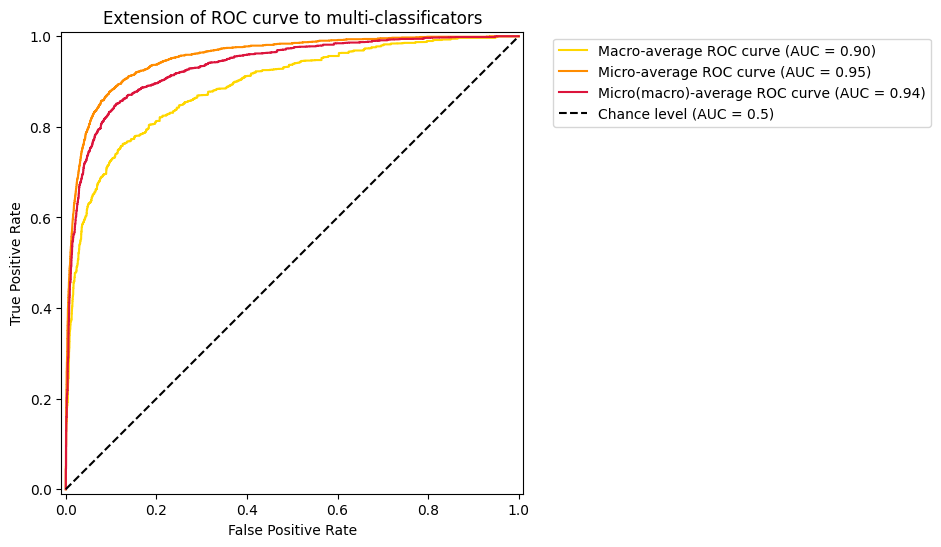

In [46]:
draw_roccurve_classification(categories=["Автотовары",
                                        "Бытовая&техника",
                                        "Детям",
                                        "Здоровье",
                                        "Мебель",
                                        "Обувь",
                                        "Товары&для&взрослых",
                                        "Электроника",
                                        "Ювелирные&изделия"],
                             data_dir=data_dir,
                             models_path=Path.cwd() / "models_categories" / "models_efficientnetv2_s",
                             pretrain_model=pretrain_model,
                             processor=processor,
                             device=device,
                             BATCH_SIZE=BATCH_SIZE,
                             SEED=SEED)

### мусор roc corve

roc-auc для всех моделей

In [285]:
a1 = np.array([[1,2], [3,4]])
a2 = np.array([[5,6], [2,5], [6,7]])

In [302]:
a1.shape, a2.shape

((2, 2), (3, 2))

In [288]:
np.mean((np.mean(a1, axis=0), np.mean(a2, axis=0)), axis=0)

array([3.16666667, 4.5       ])

In [291]:
np.mean(np.vstack((a1, a2)), axis=0)

array([3.4, 4.8])

roc-auc для одной модели

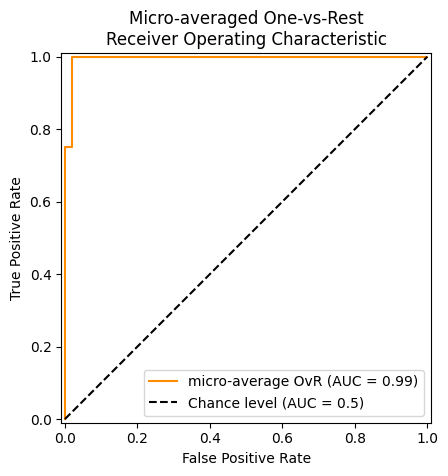

In [79]:
display = RocCurveDisplay.from_predictions(
    (np.where(ytest == 0, ytest, -1)),
    probs[:, 0],
    pos_label=0,
    name="micro-average OvR",
    color="darkorange",
    plot_chance_level=True,
)
_ = display.ax_.set(
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    title="Micro-averaged One-vs-Rest\nReceiver Operating Characteristic",
)

In [34]:
ytest

tensor([3, 4, 4, 0, 3, 5, 2, 4, 1, 3, 4, 1, 4, 4, 5, 1, 2, 4, 4, 4, 5, 0, 4, 4,
        4, 2, 1, 3, 4, 4, 4, 4, 5, 4, 4, 4, 0, 4, 4, 2, 4, 4, 4, 4, 4, 3, 4, 4,
        4, 4, 4, 4, 0])

In [39]:
(np.where(ytest == 0, ytest, -1))

array([-1, -1, -1,  0, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1,  0, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1,  0, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1,  0], dtype=int64)

In [227]:
calculate_roc_curve_micro(ytest, probs,  {0: "a", 1: "a", 2: "a"}, np.insert(np.unique(probs), 0, 0))

(array([0.        , 0.11111111, 0.11111111, 0.11111111, 0.11111111,
        0.33333333, 0.5       , 1.        , 1.        ]),
 array([0.        , 0.        , 0.33333333, 0.66666667, 0.83333333,
        0.83333333, 0.83333333, 0.83333333, 1.        ]))

In [180]:
y_pred = torch.Tensor([0,1,2,0])
probs = torch.Tensor([[0.6, 0.2, 0.2], [0.2,0.55,0.25], [0.3,0.3,0.4], [0.7,0.2,0.1]]).detach().numpy()
ytest = torch.Tensor([0,1,2,2])
y_testbin = torch.Tensor([[1,0,0], [0,1,0], [0,0,1], [0,0,1]])

In [189]:
metrics = binary_clf_curve_for_thresholds(probs, ytest, 0, np.insert(np.unique(probs[:, 0]), 0, 0))
metrics

{'tps': [1, 1, 1, 0, 0],
 'fps': [3, 2, 1, 1, 0],
 'fns': [0, 0, 0, 1, 1],
 'tns': [0, 1, 2, 2, 3]}

In [196]:
np.insert(np.unique(probs[:, 0]), 0, 0)

array([0. , 0.2, 0.3, 0.6, 0.7], dtype=float32)

In [202]:
(np.array(metrics["fps"]) / (np.array(metrics["fps"]) + np.array(metrics["tns"])))[::-1]

array([0.        , 0.33333333, 0.33333333, 0.66666667, 1.        ])

In [203]:
(np.array(metrics["tps"]) / (np.array(metrics["tps"]) + np.array(metrics["fns"])))[::-1]

array([0., 0., 1., 1., 1.])

In [47]:
binary_clf_curve(ytest, probs[:,0], 0)

(array([1, 1, 2, 3], dtype=int64),
 array([0, 1, 1, 1]),
 array([0.7, 0.6, 0.3, 0.2], dtype=float32))

In [210]:
fpr1, tpr1, _ = roc_curve(np.where(ytest == 0, ytest, -1), probs[:, 0], pos_label=0, drop_intermediate=False)
fpr2, tpr2, _ = roc_curve(np.where(ytest == 1, ytest, -1), probs[:, 1], pos_label=1, drop_intermediate=False)
fpr3, tpr3, _ = roc_curve(np.where(ytest == 2, ytest, -1), probs[:, 2], pos_label=2, drop_intermediate=False)

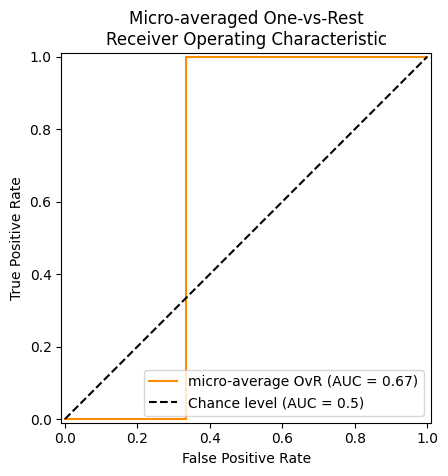

In [60]:
display = RocCurveDisplay.from_predictions(
    np.where(ytest == 0, ytest, -1),
    probs[:, 0],
    pos_label=0,
    name="micro-average OvR",
    color="darkorange",
    plot_chance_level=True,
    drop_intermediate=False
)
_ = display.ax_.set(
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    title="Micro-averaged One-vs-Rest\nReceiver Operating Characteristic",
)

тьюториал из [sklaern](https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html)

In [24]:
from sklearn.datasets import make_classification
from sklearn.svm import SVC

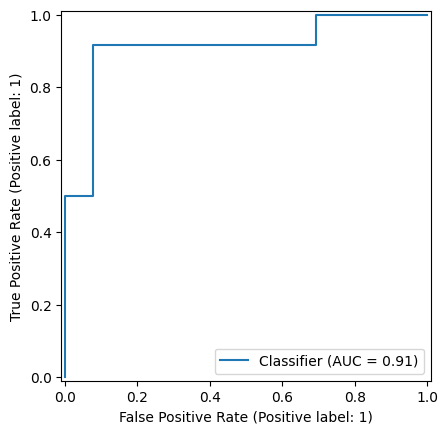

In [25]:
X, y = make_classification(random_state=0)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, random_state=0)
clf = SVC(random_state=0).fit(X_train, y_train)
y_pred = clf.decision_function(X_test)
RocCurveDisplay.from_predictions(
   y_test, y_pred)

plt.show()

In [27]:
y_pred

array([ 0.64486643, -0.85075125,  0.48293928, -1.27476131, -0.55330807,
        0.12646559,  1.14070893, -0.86382715, -0.328133  ,  0.11486231,
        1.58035975, -0.62832807, -0.73370502, -0.35207723, -0.89652696,
        0.65648549, -0.55407118, -0.66486087,  0.62261375,  1.20936176,
        0.50380356, -1.09923271,  0.24798007, -0.6477504 , -0.44679984])

In [125]:
from sklearn.linear_model import LogisticRegression
from sklearn.datasets import load_iris
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import RocCurveDisplay

In [148]:
iris = load_iris()
target_names = iris.target_names
X, y = iris.data, iris.target
y = iris.target_names[y]

random_state = np.random.RandomState(0)
n_samples, n_features = X.shape
n_classes = len(np.unique(y))
X = np.concatenate([X, random_state.randn(n_samples, 200 * n_features)], axis=1)
(
    X_train,
    X_test,
    y_train,
    y_test,
) = train_test_split(X, y, test_size=0.5, stratify=y, random_state=0)

In [149]:
classifier = LogisticRegression()
y_score = classifier.fit(X_train, y_train).predict_proba(X_test)

In [150]:
label_binarizer = LabelBinarizer().fit(y_train)
y_onehot_test = label_binarizer.transform(y_test)
y_onehot_test.shape  # (n_samples, n_classes)

(75, 3)

In [151]:
label_binarizer.transform(["virginica"])

array([[0, 0, 1]])

In [152]:
class_of_interest = "virginica"
class_id = np.flatnonzero(label_binarizer.classes_ == class_of_interest)[0]
class_id

2

In [153]:
y_score #[:, class_id]

array([[0.38095776, 0.05072909, 0.56831315],
       [0.07031555, 0.27915668, 0.65052777],
       [0.32518843, 0.0920671 , 0.58274447],
       [0.66083178, 0.13605963, 0.20310859],
       [0.09502454, 0.1913814 , 0.71359406],
       [0.64647439, 0.05039354, 0.30313206],
       [0.1543094 , 0.29525714, 0.55043345],
       [0.66859233, 0.23292731, 0.09848036],
       [0.01797098, 0.26808171, 0.71394731],
       [0.470709  , 0.14814238, 0.38114862],
       [0.70272109, 0.02149585, 0.27578306],
       [0.62845106, 0.0909246 , 0.28062433],
       [0.03402058, 0.91136371, 0.05461571],
       [0.8887887 , 0.07273617, 0.03847513],
       [0.0325917 , 0.13058552, 0.83682278],
       [0.78954536, 0.09636036, 0.11409427],
       [0.13225894, 0.23406469, 0.63367637],
       [0.54612789, 0.21527602, 0.2385961 ],
       [0.61594773, 0.11086636, 0.27318591],
       [0.71002407, 0.14652079, 0.14345514],
       [0.07669563, 0.63436711, 0.28893726],
       [0.77655538, 0.08614687, 0.13729774],
       [0.

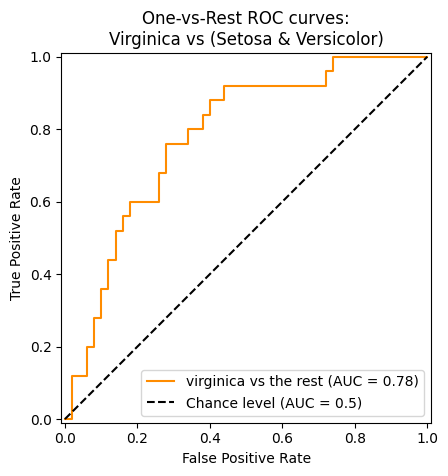

In [154]:
display = RocCurveDisplay.from_predictions(
    y_onehot_test[:, class_id],
    y_score[:, class_id],
    name=f"{class_of_interest} vs the rest",
    color="darkorange",
    plot_chance_level=True,
)
_ = display.ax_.set(
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    title="One-vs-Rest ROC curves:\nVirginica vs (Setosa & Versicolor)",
)

In [155]:
print(f"y_score:\n{y_score[0:2,:]}")
print()
print(f"y_score.ravel():\n{y_score[0:2,:].ravel()}")

y_score:
[[0.38095776 0.05072909 0.56831315]
 [0.07031555 0.27915668 0.65052777]]

y_score.ravel():
[0.38095776 0.05072909 0.56831315 0.07031555 0.27915668 0.65052777]


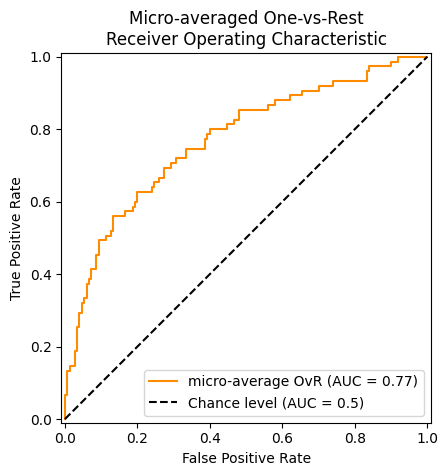

In [156]:
display = RocCurveDisplay.from_predictions(
    y_onehot_test.ravel(),
    y_score.ravel(),
    name="micro-average OvR",
    color="darkorange",
    plot_chance_level=True,
)
_ = display.ax_.set(
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    title="Micro-averaged One-vs-Rest\nReceiver Operating Characteristic",
)

In [157]:
from sklearn.metrics import roc_auc_score

micro_roc_auc_ovr = roc_auc_score(
    y_test,
    y_score,
    multi_class="ovr",
    average="micro",
)

print(f"Micro-averaged One-vs-Rest ROC AUC score:\n{micro_roc_auc_ovr:.2f}")

Micro-averaged One-vs-Rest ROC AUC score:
0.77


In [158]:
from sklearn.metrics import auc, roc_curve

# store the fpr, tpr, and roc_auc for all averaging strategies
fpr, tpr, roc_auc = dict(), dict(), dict()
# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_onehot_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

print(f"Micro-averaged One-vs-Rest ROC AUC score:\n{roc_auc['micro']:.2f}")


Micro-averaged One-vs-Rest ROC AUC score:
0.77


In [174]:
len(fpr["micro"])

88

In [159]:
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_onehot_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

fpr_grid = np.linspace(0.0, 1.0, 1000)

# Interpolate all ROC curves at these points
mean_tpr = np.zeros_like(fpr_grid)

for i in range(n_classes):
    mean_tpr += np.interp(fpr_grid, fpr[i], tpr[i])  # linear interpolation

# Average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = fpr_grid
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

print(f"Macro-averaged One-vs-Rest ROC AUC score:\n{roc_auc['macro']:.2f}")

Macro-averaged One-vs-Rest ROC AUC score:
0.78


In [175]:
len(fpr["macro"])

1000

In [179]:
fpr[2].shape

(34,)

In [171]:
xp = [1, 2, 3]
fp = [3, 2, 0]
x=2.5

In [173]:
fp = np.asarray(fp)
fp

array([3, 2, 0])

In [169]:
# tpr["macro"]

In [164]:
fpr_grid

array([0.        , 0.001001  , 0.002002  , 0.003003  , 0.004004  ,
       0.00500501, 0.00600601, 0.00700701, 0.00800801, 0.00900901,
       0.01001001, 0.01101101, 0.01201201, 0.01301301, 0.01401401,
       0.01501502, 0.01601602, 0.01701702, 0.01801802, 0.01901902,
       0.02002002, 0.02102102, 0.02202202, 0.02302302, 0.02402402,
       0.02502503, 0.02602603, 0.02702703, 0.02802803, 0.02902903,
       0.03003003, 0.03103103, 0.03203203, 0.03303303, 0.03403403,
       0.03503504, 0.03603604, 0.03703704, 0.03803804, 0.03903904,
       0.04004004, 0.04104104, 0.04204204, 0.04304304, 0.04404404,
       0.04504505, 0.04604605, 0.04704705, 0.04804805, 0.04904905,
       0.05005005, 0.05105105, 0.05205205, 0.05305305, 0.05405405,
       0.05505506, 0.05605606, 0.05705706, 0.05805806, 0.05905906,
       0.06006006, 0.06106106, 0.06206206, 0.06306306, 0.06406406,
       0.06506507, 0.06606607, 0.06706707, 0.06806807, 0.06906907,
       0.07007007, 0.07107107, 0.07207207, 0.07307307, 0.07407

In [165]:
fpr[0] #x

array([0.  , 0.  , 0.  , 0.02, 0.02, 0.04, 0.04, 0.06, 0.06, 0.08, 0.08,
       0.14, 0.14, 0.22, 0.22, 0.24, 0.24, 0.38, 0.38, 0.68, 0.68, 0.72,
       0.72, 1.  ])

In [166]:
tpr[0]

array([0.  , 0.04, 0.4 , 0.4 , 0.52, 0.52, 0.56, 0.56, 0.68, 0.68, 0.76,
       0.76, 0.8 , 0.8 , 0.84, 0.84, 0.88, 0.88, 0.92, 0.92, 0.96, 0.96,
       1.  , 1.  ])

In [163]:
np.interp(fpr_grid, fpr[0], tpr[0])

array([0.4 , 0.4 , 0.4 , 0.4 , 0.4 , 0.4 , 0.4 , 0.4 , 0.4 , 0.4 , 0.4 ,
       0.4 , 0.4 , 0.4 , 0.4 , 0.4 , 0.4 , 0.4 , 0.4 , 0.4 , 0.52, 0.52,
       0.52, 0.52, 0.52, 0.52, 0.52, 0.52, 0.52, 0.52, 0.52, 0.52, 0.52,
       0.52, 0.52, 0.52, 0.52, 0.52, 0.52, 0.52, 0.56, 0.56, 0.56, 0.56,
       0.56, 0.56, 0.56, 0.56, 0.56, 0.56, 0.56, 0.56, 0.56, 0.56, 0.56,
       0.56, 0.56, 0.56, 0.56, 0.56, 0.68, 0.68, 0.68, 0.68, 0.68, 0.68,
       0.68, 0.68, 0.68, 0.68, 0.68, 0.68, 0.68, 0.68, 0.68, 0.68, 0.68,
       0.68, 0.68, 0.68, 0.76, 0.76, 0.76, 0.76, 0.76, 0.76, 0.76, 0.76,
       0.76, 0.76, 0.76, 0.76, 0.76, 0.76, 0.76, 0.76, 0.76, 0.76, 0.76,
       0.76, 0.76, 0.76, 0.76, 0.76, 0.76, 0.76, 0.76, 0.76, 0.76, 0.76,
       0.76, 0.76, 0.76, 0.76, 0.76, 0.76, 0.76, 0.76, 0.76, 0.76, 0.76,
       0.76, 0.76, 0.76, 0.76, 0.76, 0.76, 0.76, 0.76, 0.76, 0.76, 0.76,
       0.76, 0.76, 0.76, 0.76, 0.76, 0.76, 0.76, 0.76, 0.8 , 0.8 , 0.8 ,
       0.8 , 0.8 , 0.8 , 0.8 , 0.8 , 0.8 , 0.8 , 0.

In [18]:
macro_roc_auc_ovr = roc_auc_score(
    y_test,
    y_score,
    multi_class="ovr",
    average="macro",
)

print(f"Macro-averaged One-vs-Rest ROC AUC score:\n{macro_roc_auc_ovr:.2f}")

Macro-averaged One-vs-Rest ROC AUC score:
0.78


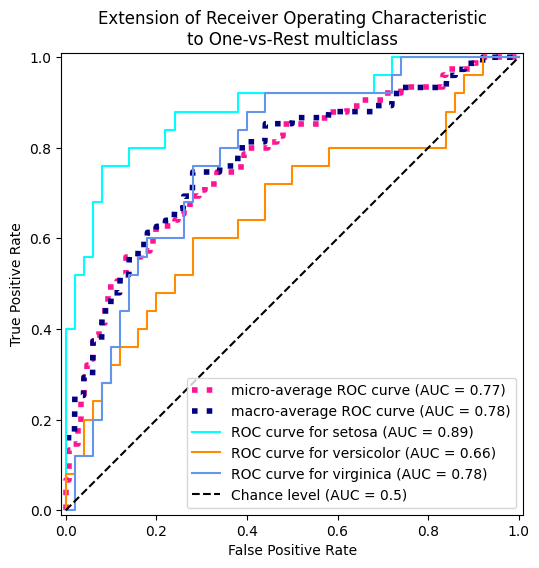

In [19]:
from itertools import cycle

fig, ax = plt.subplots(figsize=(6, 6))

plt.plot(
    fpr["micro"],
    tpr["micro"],
    label=f"micro-average ROC curve (AUC = {roc_auc['micro']:.2f})",
    color="deeppink",
    linestyle=":",
    linewidth=4,
)

plt.plot(
    fpr["macro"],
    tpr["macro"],
    label=f"macro-average ROC curve (AUC = {roc_auc['macro']:.2f})",
    color="navy",
    linestyle=":",
    linewidth=4,
)

colors = cycle(["aqua", "darkorange", "cornflowerblue"])
for class_id, color in zip(range(n_classes), colors):
    RocCurveDisplay.from_predictions(
        y_onehot_test[:, class_id],
        y_score[:, class_id],
        name=f"ROC curve for {target_names[class_id]}",
        color=color,
        ax=ax,
        plot_chance_level=(class_id == 2),
    )

_ = ax.set(
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    title="Extension of Receiver Operating Characteristic\nto One-vs-Rest multiclass",
)

___

### мусор pr curve

In [28]:
tps, fps, fns = calculate_precision_recall_curve_micro(ytest, probs, idx2target, for_all_models=True)

In [30]:
np.mean(np.vstack((tps, fps)), axis=0).shape

(319,)

In [248]:
pr, rec, th = calculate_precision_recall_curve_macro(ytest, probs, idx2target, np.insert(np.unique(probs), 0, 0))

In [262]:
np.mean(np.vstack((rec, pr)), axis=0).shape

(319,)

In [259]:
rec.shape

(319,)

микроусреднение

In [180]:
precision_micro, recall_micro = calculate_precision_recall_curve_micro(ytest, probs, idx2target)

C:\temp\ipykernel_5520\3265472326.py:22: RuntimeWarning: invalid value encountered in divide
  precisions = tps_mean / (tps_mean + fps_mean)


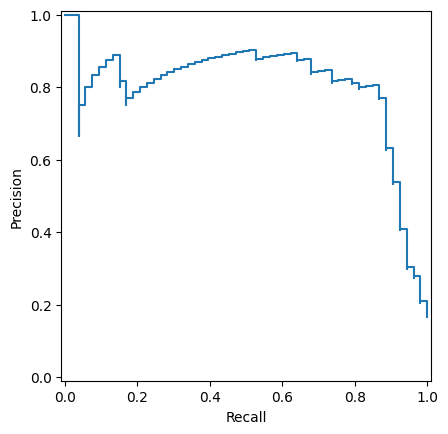

In [181]:
disp = PrecisionRecallDisplay(precision=precision_micro,
                              recall=recall_micro)
disp.plot();

In [184]:
enc = OneHotEncoder()

In [190]:
a1 = enc.fit_transform(ytest.detach().cpu().numpy().reshape((-1,1)))

In [194]:
a1 = a1.toarray()

In [198]:
a, b, c = precision_recall_curve(a1.ravel(), probs.ravel())

In [199]:
average_precision_score(a1, probs, average="micro")

0.8015374757291276

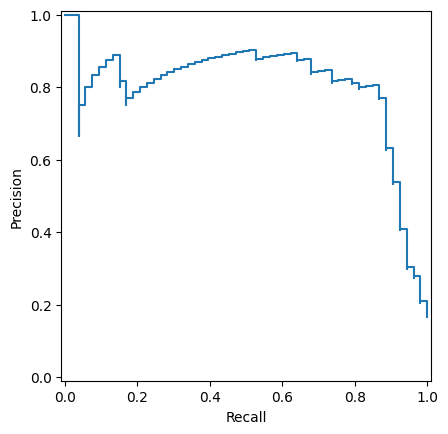

In [196]:
disp = PrecisionRecallDisplay(precision=a, recall=b)
disp.plot();

In [174]:
calculate_precision_recall_curve_micro(ytest, probs, {0: "a", 1: "a", 2: "a"})

[2.66666667 2.66666667 1.33333333 1.         0.33333333 0.33333333 0.33333333 0.33333333
 0.        ]
[1.33333333 1.         1.         1.         1.         0.66666667 0.33333333 0.
 0.        ]


C:\temp\ipykernel_5520\2728422479.py:22: RuntimeWarning: invalid value encountered in divide
  precisions = tps_mean / (tps_mean + fps_mean)


(array([0.33333333, 0.27272727, 0.42857143, 0.5       , 0.75      , 0.66666667,
        0.5       , 0.        , 1.        ]),
 array([1.  , 0.75, 0.75, 0.75, 0.75, 0.5 , 0.25, 0.  , 0.  ]))

In [156]:
y_pred = torch.Tensor([0,1,2,0])
probs = torch.Tensor([[0.6, 0.2, 0.2], [0.2,0.55,0.25], [0.3,0.3,0.4], [0.7,0.2,0.1]]).detach().numpy()
ytest = torch.Tensor([0,1,2,2])
y_testbin = torch.Tensor([[1,0,0], [0,1,0], [0,0,1], [0,0,1]])


a, b, c = precision_recall_curve(y_testbin.ravel(), probs.ravel())
a, b, c

(array([0.33333333, 0.27272727, 0.42857143, 0.5       , 0.75      , 0.66666667,
        0.5       , 0.        , 1.        ]),
 array([1.  , 0.75, 0.75, 0.75, 0.75, 0.5 , 0.25, 0.  , 0.  ]),
 array([0.1 , 0.2 , 0.25, 0.3 , 0.4 , 0.55, 0.6 , 0.7 ], dtype=float32))

In [146]:
# metrics = binary_clf_curve_for_thresholds(probs, ytest, 0)

In [149]:
for i in [0,1,2]:
    metrics = binary_clf_curve_for_thresholds(probs, ytest, i)
    
    if i == 0:
        tps = np.array(metrics["tps"])
        fps = np.array(metrics["fps"])
        fns = np.array(metrics["fns"])
    else:
        tps = np.vstack((tps, metrics["tps"]))
        fps = np.vstack((fps, metrics["fps"]))
        fns = np.vstack((fns, metrics["fns"]))

In [152]:
tps_mean = np.mean(tps, axis=0)
fps_mean = np.mean(fps, axis=0)
fns_mean = np.mean(fns, axis=0)

In [158]:
pr = tps_mean / (tps_mean + fps_mean)
rec = tps_mean / (tps_mean + fns_mean)
pr, rec

C:\temp\ipykernel_5520\494094961.py:1: RuntimeWarning: invalid value encountered in divide
  pr = tps_mean / (tps_mean + fps_mean)


(array([0.33333333, 0.27272727, 0.42857143, 0.5       , 0.75      , 0.66666667,
        0.5       , 0.        ,        nan]),
 array([1.  , 0.75, 0.75, 0.75, 0.75, 0.5 , 0.25, 0.  , 0.  ]))

In [116]:
binary_clf_curve(ytest, probs[:, 0], 0)    # fps, tps

(array([1, 1, 2, 3], dtype=int64),
 array([0, 1, 1, 1]),
 array([0.7, 0.6, 0.3, 0.2], dtype=float32))

In [207]:
average_precision_score(ytest, probs, average="micro")

0.8015374757291276

In [208]:
enc = OneHotEncoder()
y_truebin = enc.fit_transform(ytest.reshape((-1,1)))
y_truebin = y_truebin.toarray()

In [209]:
average_precision_score(y_truebin, probs, average="micro")

0.8015374757291276

In [210]:
average_precision_score(ytest, probs, average="macro")

0.7621610240527915

In [211]:
average_precision_score(y_truebin, probs, average="macro")

0.7621610240527915

макроусреднение

In [90]:
precision_macro, recall_macro, thresholds = calculate_precision_recall_curve_macro(ytest, probs, idx2target)

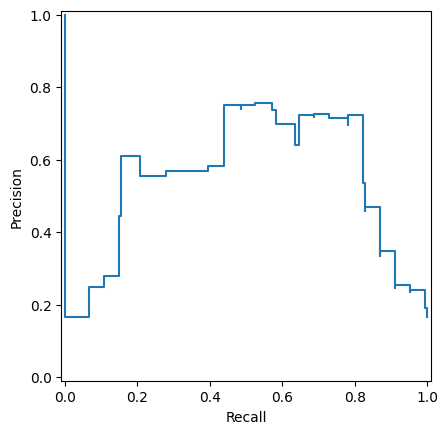

In [91]:
disp = PrecisionRecallDisplay(precision=precision_macro,
                              recall=recall_macro)
disp.plot();

In [84]:
precision_macro, recall_macro, thresholds = calculate_precision_recall_curve_macro(ytest, probs, {0: "a", 1: "a", 2: "a"})

In [39]:
thresholds = np.insert(np.unique(probs), 0, 0)
thresholds

array([0.  , 0.1 , 0.2 , 0.25, 0.3 , 0.4 , 0.55, 0.6 , 0.7 ], dtype=float32)

In [40]:
# pr1s, rec1s = [], []
# pr2s, rec2s = [], []
# pr3s, rec3s = [], []

# for th in thresholds:
#     pr1, rec1, _ = calculate_metrics_by_class(probs, ytest, class_ind=0, threshold=th)
#     pr2, rec2, _ = calculate_metrics_by_class(probs, ytest, class_ind=1, threshold=th)
#     pr3, rec3, _ = calculate_metrics_by_class(probs, ytest, class_ind=2, threshold=th)
    
#     pr1s.append(pr1)
#     rec1s.append(rec1)
#     pr2s.append(pr2)
#     rec2s.append(rec2)
#     pr3s.append(pr3)
#     rec3s.append(rec3)

In [65]:
precision = defaultdict(list)
recall = defaultdict(list)

for th in thresholds:
    for i in list([0, 1, 2]):
        pr, rec, _ = calculate_metrics_by_class(probs, ytest, class_ind=i, threshold=th)
        precision[i].append(pr)
        recall[i].append(rec)

In [75]:
arr = False
for key in precision.keys():
    if not arr:
        precisions = np.array(precision[key])
        recalls = np.array(recall[key])
        arr = True
    else:
        precisions = np.vstack((precisions, precision[key]))
        recalls = np.vstack((recalls, recall[key]))

In [69]:
precisions[:, -1] = 1.0

In [70]:
precisions

array([[0.25      , 0.25      , 0.33333333, 0.33333333, 0.5       , 0.5       ,
        0.5       , 0.        , 1.        ],
       [0.25      , 0.25      , 0.5       , 0.5       , 1.        , 1.        ,
        0.        , 0.        , 1.        ],
       [0.5       , 0.33333333, 0.5       , 1.        , 1.        , 0.        ,
        0.        , 0.        , 1.        ]])

In [71]:
np.mean(precisions, axis=0)

array([0.33333333, 0.27777778, 0.44444444, 0.61111111, 0.83333333, 0.5       ,
       0.16666667, 0.        , 1.        ])

In [73]:
np.mean(recalls, axis=0)

array([1.        , 0.83333333, 0.83333333, 0.83333333, 0.83333333, 0.66666667,
       0.33333333, 0.        , 0.        ])

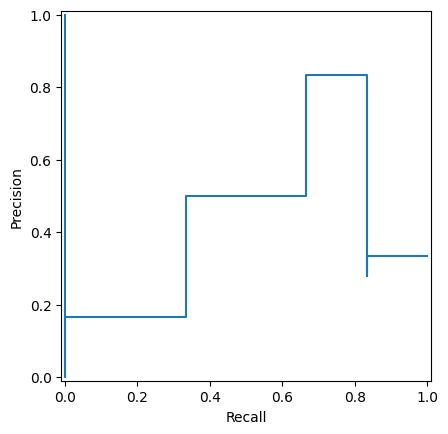

In [74]:
disp = PrecisionRecallDisplay(precision=np.mean(precisions, axis=0),
                              recall=np.mean(recalls, axis=0))
disp.plot();

In [202]:
# a, b, c = precision_recall_curve(ytest, probs[:, 2], pos_label=2)
# a, b, c

In [203]:
# disp = PrecisionRecallDisplay(precision=a, recall=b)
# disp.plot();

In [35]:
# pr4s, rec4s

In [36]:
# probs = torch.Tensor([[0,0.6], [0,0.2], [0,0.2], [0,0.2], [0,0.55], [0,0.25],
#                       [0,0.3], [0,0.3], [0,0.4], [0,0.7], [0,0.2], [0,0.1]]).detach().numpy()

In [39]:
# pr4s, rec4s = [], []

# for th in [0, 0.1 , 0.2 , 0.25, 0.3 , 0.4 , 0.55, 0.6 , 0.7]:
#     pr4, rec4, _ = calculate_metrics_by_class(probs, y_predbin.ravel(), class_ind=1, threshold=th)
    
#     pr4s.append(pr4)
#     rec4s.append(rec4)

In [204]:
# calculate_precision_recall_curve(ytest, probs, class_ind=2)

In [ ]:
#def calculate_precision_recall_curve_macro(y_true, probs, class_ind : int):

макроусреднение

In [50]:
np.mean(np.array([rec1s, rec2s, rec3s]), axis=0)

array([1.        , 0.83333333, 0.83333333, 0.83333333, 0.83333333, 0.66666667,
       0.33333333, 0.        , 0.        ])

In [214]:
# test = np.array([pr1s, pr2s, pr3s])
# test[:, -1] = 9

In [47]:
np.array([pr1s, pr2s, pr3s])

array([[0.25      , 0.25      , 0.33333333, 0.33333333, 0.5       , 0.5       ,
        0.5       , 0.        , 0.        ],
       [0.25      , 0.25      , 0.5       , 0.5       , 1.        , 1.        ,
        0.        , 0.        , 0.        ],
       [0.5       , 0.33333333, 0.5       , 1.        , 1.        , 0.        ,
        0.        , 0.        , 0.        ]])

In [205]:
# disp = PrecisionRecallDisplay(precision=pr1s, recall=rec1s)
# disp.plot();

In [49]:
pr1s[-1] = 1.0
pr2s[-1] = 1.0
pr3s[-1] = 1.0

# np.array([pr1s, pr2s, pr3s])
np.mean(np.array([pr1s, pr2s, pr3s]), axis=0)

array([0.33333333, 0.27777778, 0.44444444, 0.61111111, 0.83333333, 0.5       ,
       0.16666667, 0.        , 1.        ])

In [171]:
probs[:, 0]

array([0.6, 0.2, 0.3, 0.7], dtype=float32)

In [179]:
# for th in [0, 0.1 , 0.2 , 0.25, 0.3 , 0.4 , 0.55, 0.6 , 0.7]:
#     pr1, rec1, _ = calculate_metrics_by_class(probs, ytest, class_ind=0, threshold=th)
#     print(pr1)

0.25
0.25
0.3333333333333333
0.3333333333333333
0.5
0.5
0.5
0.0
0.0


In [46]:
pr1s, rec1s = [], []
pr2s, rec2s = [], []
pr3s, rec3s = [], []

for th in [0, 0.1 , 0.2 , 0.25, 0.3 , 0.4 , 0.55, 0.6 , 0.7]:
    pr1, rec1, _ = calculate_metrics_by_class(probs, ytest, class_ind=0, threshold=th)
    pr2, rec2, _ = calculate_metrics_by_class(probs, ytest, class_ind=1, threshold=th)
    pr3, rec3, _ = calculate_metrics_by_class(probs, ytest, class_ind=2, threshold=th)
    
    pr1s.append(pr1)
    rec1s.append(rec1)
    pr2s.append(pr2)
    rec2s.append(rec2)
    pr3s.append(pr3)
    rec3s.append(rec3)

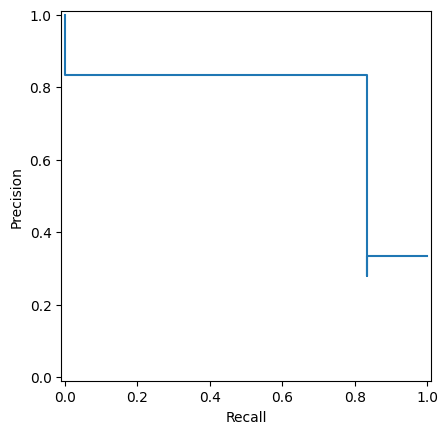

In [150]:
disp = PrecisionRecallDisplay(precision=np.mean(np.array([pr1s, pr2s, pr3s]), axis=0), recall=np.mean(np.array([rec1s, rec2s, rec3s]), axis=0))
disp.plot();

In [39]:
model_name

'Товары&для&взрослых'

In [78]:
precision = defaultdict()
recall = defaultdict()
average_precision = defaultdict()

for i in list(idx2target.keys()):
    precision[i], recall[i], _ = precision_recall_curve(ytest, probs[:, i], pos_label=i)
    average_precision[i] = average_precision_score(np.where(ytest==i, True, False) * 1, probs[:, i], pos_label=1)

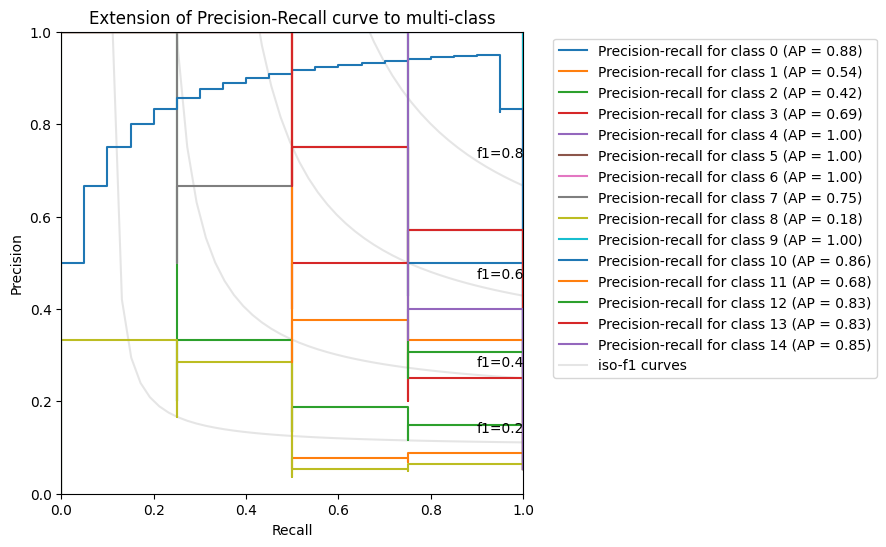

In [79]:
# возможно имеет смысл подобрать цветовую гамму

_, ax = plt.subplots(figsize=(6, 6))

f_scores = np.linspace(0.2, 0.8, num=4)
for f_score in f_scores:
    x = np.linspace(0.01, 1)
    y = f_score * x / (2 * x - f_score)
    (l,) = plt.plot(x[y >= 0], y[y >= 0], color="gray", alpha=0.2)
    plt.annotate("f1={0:0.1f}".format(f_score), xy=(0.9, y[45] + 0.02))

# newcmap = np.vstack((plt.cm.cool(np.linspace(0,1,3)), plt.cm.viridis(np.linspace(0,1,3))))
# plt.rcParams["axes.prop_cycle"] = plt.cycler("color", newcmap)
    
for i in list(idx2target.keys()):
    display = PrecisionRecallDisplay(
        recall=recall[i],
        precision=precision[i],
        average_precision=average_precision[i],
    )
    display.plot(ax=ax, name=f"Precision-recall for class {i}")

handles, labels = display.ax_.get_legend_handles_labels()
handles.extend([l])
labels.extend(["iso-f1 curves"])
# ax.legend(handles=handles, labels=labels, loc="best")
ax.legend(handles=handles, labels=labels, bbox_to_anchor=(1.05, 1.0), loc='upper left')
ax.set_title("Extension of Precision-Recall curve to multi-class")

plt.ylim([0, 1])
plt.xlim([0, 1])
plt.show()

In [32]:
precision, recall, thresholds = precision_recall_curve(ytest, probs[:, 1], pos_label=1)
#precision_recall_curve(ytest, probs[:, 1], pos_label=1)

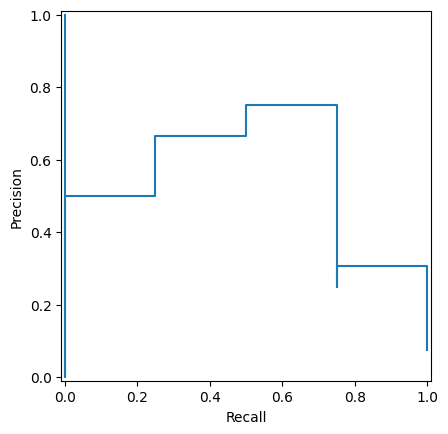

In [33]:
disp = PrecisionRecallDisplay(precision=precision, recall=recall)
disp.plot();

In [120]:
from itertools import cycle

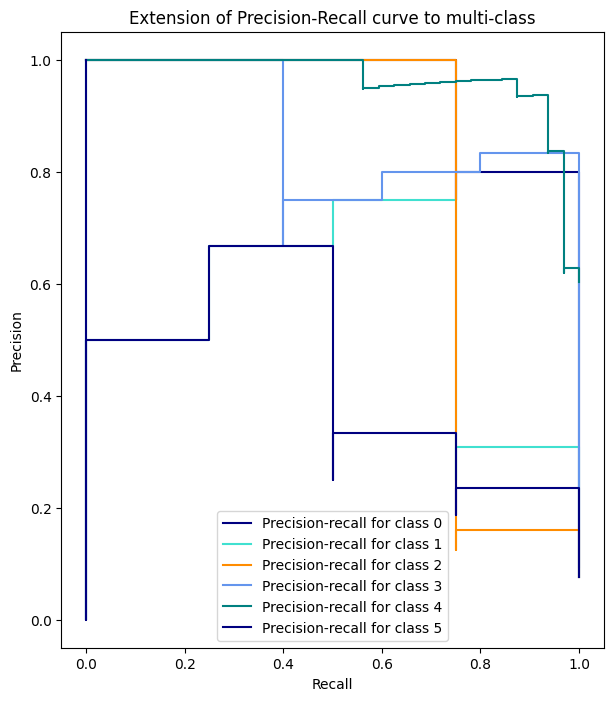

In [48]:
colors = cycle(["navy", "turquoise", "darkorange", "cornflowerblue", "teal"])

_, ax = plt.subplots(figsize=(7, 8))


for i, color in zip(list(idx2target.keys()), colors):
    display = PrecisionRecallDisplay(
        recall=recall[i],
        precision=precision[i],
    )
    display.plot(ax=ax, name=f"Precision-recall for class {i}", color=color)

handles, labels = display.ax_.get_legend_handles_labels()
ax.legend(handles=handles, labels=labels, loc="best")
ax.set_title("Extension of Precision-Recall curve to multi-class")

plt.show()

___

написание [binary_clf_curve](https://github.com/scikit-learn/scikit-learn/blob/8721245511de2f225ff5f9aa5f5fadce663cd4a3/sklearn/metrics/_ranking.py#L780) и [calculate_precision_recall_curve](https://github.com/scikit-learn/scikit-learn/blob/8721245511de2f225ff5f9aa5f5fadce663cd4a3/sklearn/metrics/_ranking.py#L875) (собраем из исходнков sklearn)

еще полезные ссылки [1](https://github.com/scikit-learn/scikit-learn/blob/8721245511de2f225ff5f9aa5f5fadce663cd4a3/sklearn/utils/extmath.py#L1205) [2](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_recall_curve.html) [3](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.PrecisionRecallDisplay.html#sklearn.metrics.PrecisionRecallDisplay)

In [304]:
y_score = np.array([0.1, 0.4, 0.35, 0.8])

In [207]:
# по возрастанию
desc_score_indices = np.argsort(y_score, kind="mergesort")
desc_score_indices

array([0, 2, 1, 3], dtype=int64)

In [208]:
y_score[desc_score_indices]

array([0.1 , 0.35, 0.4 , 0.8 ])

In [305]:
# по убыванию
desc_score_indices = np.argsort(y_score, kind="mergesort")[::-1]
desc_score_indices

array([3, 1, 2, 0], dtype=int64)

In [298]:
y_score = y_score[desc_score_indices]
y_score

array([0.8 , 0.4 , 0.35, 0.1 ])

In [212]:
# np.diff(y_score)

array([-0.4 , -0.05, -0.25])

In [218]:
# distinct_value_indices = np.where(np.diff(y_score))[0]
# distinct_value_indices

array([0, 1, 2], dtype=int64)

In [222]:
# [distinct_value_indices, 4 - 1]

[array([0, 1, 2], dtype=int64), 3]

In [225]:
# threshold_idxs = np.r_[distinct_value_indices, 4 - 1]
# threshold_idxs

array([0, 1, 2, 3], dtype=int64)

In [226]:
# y_score[threshold_idxs]

array([0.8 , 0.4 , 0.35, 0.1 ])

In [327]:
y_true = [0,0,1,1]
y_true

[0, 0, 1, 1]

In [328]:
# та же булевая маска
y_true = y_true == np.array([1]*4)
y_true

array([False, False,  True,  True])

In [329]:
# поменяли местами так же как индексы
y_true = y_true[desc_score_indices]
y_true

array([ True, False,  True, False])

In [331]:
y_true * 1

array([1, 0, 1, 0])

In [330]:
tps = np.cumsum(y_true * 1)
expected = np.sum(y_true)
print(np.allclose(tps.take(-1), expected))
print(tps)
print(expected)

True
[1 1 2 2]
2


In [282]:
# threshold_idxs взять индекс как цифру 
fps = 1 + threshold_idxs - tps
fps

array([0, 1, 1, 2], dtype=int64)

In [283]:
ps = tps + fps
ps

array([1, 2, 3, 4], dtype=int64)

In [284]:
recall = tps / tps[-1]
recall

array([0.5, 0.5, 1. , 1. ])

In [285]:
precision = np.zeros_like(tps, dtype=np.float64)
np.divide(tps, ps, out=precision, where=(ps != 0))

array([1.        , 0.5       , 0.66666667, 0.5       ])

In [286]:
sl = slice(None, None, -1)
sl

slice(None, None, -1)

In [287]:
np.hstack((precision[sl], 1))

array([0.5       , 0.66666667, 0.5       , 1.        , 1.        ])

In [288]:
np.hstack((recall[sl], 0))

array([1. , 1. , 0.5, 0.5, 0. ])

In [338]:
y_score[sl]

array([0.8 , 0.35, 0.4 , 0.1 ])

In [333]:
y_true = np.array([0, 0, 1, 1])
y_scores = np.array([0.1, 0.4, 0.35, 0.8])
precision, recall, thresholds = precision_recall_curve(y_true, y_scores)
print(precision)
print(recall)
print(thresholds)

[0.5        0.66666667 0.5        1.         1.        ]
[1.  1.  0.5 0.5 0. ]
[0.1  0.35 0.4  0.8 ]


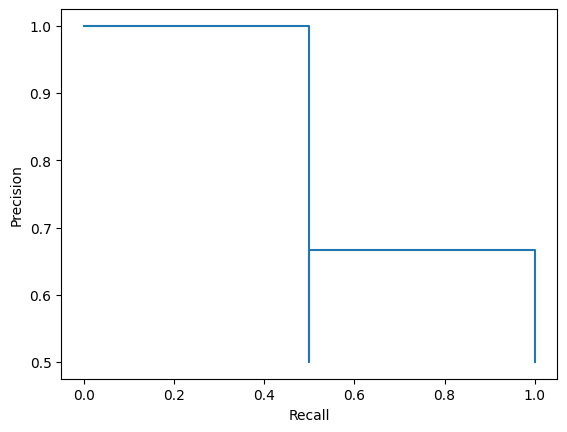

In [291]:
disp = PrecisionRecallDisplay(precision=precision, recall=recall)
disp.plot()

___

написание своих метрик - calculate_metrics_by_class

In [28]:
y_preds[:20]

[3, 4, 4, 0, 3, 5, 3, 4, 3, 3, 4, 1, 4, 4, 5, 1, 2, 4, 4, 4]

In [29]:
np.max(probs[:20], axis=1)

array([0.93460894, 0.40609345, 0.31238958, 0.75095034, 0.41255826,
       0.2737452 , 0.6976145 , 0.4165158 , 0.3835143 , 0.89608896,
       0.5138887 , 0.8178028 , 0.51397395, 0.5628263 , 0.3343404 ,
       0.8054839 , 0.34848872, 0.60559636, 0.7468036 , 0.4017948 ],
      dtype=float32)

In [30]:
probs[:20]

array([[0.01244367, 0.00491417, 0.03527798, 0.93460894, 0.00861835,
        0.00413692],
       [0.02674061, 0.37559423, 0.06265081, 0.0694088 , 0.40609345,
        0.0595121 ],
       [0.0690278 , 0.28127816, 0.09330133, 0.19986846, 0.31238958,
        0.04413467],
       [0.75095034, 0.07209243, 0.01891878, 0.06312653, 0.0679559 ,
        0.02695598],
       [0.06143581, 0.34664032, 0.03741601, 0.41255826, 0.10397744,
        0.0379721 ],
       [0.13922709, 0.06744944, 0.1130827 , 0.22849505, 0.17800052,
        0.2737452 ],
       [0.01537624, 0.04876228, 0.07932754, 0.6976145 , 0.14303435,
        0.01588508],
       [0.02025658, 0.04549378, 0.10672758, 0.3748352 , 0.4165158 ,
        0.0361711 ],
       [0.06116444, 0.17179272, 0.17927858, 0.3835143 , 0.09325162,
        0.11099833],
       [0.01269321, 0.01484618, 0.04897433, 0.89608896, 0.01855637,
        0.00884091],
       [0.11470978, 0.19059041, 0.03210991, 0.10986015, 0.5138887 ,
        0.03884107],
       [0.02646496, 0

In [31]:
class0 = probs[:, 0]
class0

array([0.01244367, 0.02674061, 0.0690278 , 0.75095034, 0.06143581,
       0.13922709, 0.01537624, 0.02025658, 0.06116444, 0.01269321,
       0.11470978, 0.02646496, 0.04845186, 0.06321364, 0.0922618 ,
       0.02537077, 0.04416846, 0.03495563, 0.05984934, 0.26460484,
       0.07392947, 0.60938174, 0.14379719, 0.02121217, 0.0584241 ,
       0.02869302, 0.04890493, 0.02697765, 0.04988291, 0.02672647,
       0.03747896, 0.13579497, 0.34772855, 0.1257295 , 0.06230728,
       0.09574022, 0.5344858 , 0.05167676, 0.16803378, 0.11399372,
       0.10982203, 0.04804206, 0.03718215, 0.11899664, 0.09487012,
       0.12546442, 0.10527912, 0.02153691, 0.05847857, 0.07949749,
       0.05432142, 0.09064288, 0.32488614], dtype=float32)

In [180]:
threshold = 0.5
true_positives = (class0 > threshold) & (np.where(ytest == 0, True, False))
precision = np.sum(true_positives) / np.sum(class0 > threshold)
recall = np.sum(true_positives) / np.sum(np.where(ytest == 0, True, False))
f1 = 2*precision*recall / (precision + recall)
print("presicion", precision)
print("recall", recall)
print("f1", f1)

presicion 1.0
recall 0.75
f1 0.8571428571428571


In [140]:
ytest

tensor([3, 4, 4, 0, 3, 5, 2, 4, 1, 3, 4, 1, 4, 4, 5, 1, 2, 4, 4, 4, 5, 0, 4, 4,
        4, 2, 1, 3, 4, 4, 4, 4, 5, 4, 4, 4, 0, 4, 4, 2, 4, 4, 4, 4, 4, 3, 4, 4,
        4, 4, 4, 4, 0])

In [103]:
np.where(np.array(y_preds) == 0, True, False) #== np.where(ytest == 0, True, False)

array([False, False, False,  True, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False,  True, False, False, False, False, False,
       False, False, False, False, False,  True, False, False, False,
        True, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False,  True])

In [89]:
# a1 = np.where(np.array(y_preds) == 0, True, False)
a2 = np.where(ytest == 0, True, False)
# np.sum(a1 & a2)

In [339]:
np.where(ytest == 0, True, False)

array([False, False, False,  True, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False,  True, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
        True, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False,  True])

In [108]:
true_positives = (class0 > threshold) & a2
true_positives

array([False, False, False,  True, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False,  True, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
        True, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False])

In [134]:
np.sum(a2)

4

In [133]:
np.sum(class0 > threshold)

3

In [121]:
ytest.numpy()

array([3, 4, 4, 0, 3, 5, 2, 4, 1, 3, 4, 1, 4, 4, 5, 1, 2, 4, 4, 4, 5, 0,
       4, 4, 4, 2, 1, 3, 4, 4, 4, 4, 5, 4, 4, 4, 0, 4, 4, 2, 4, 4, 4, 4,
       4, 3, 4, 4, 4, 4, 4, 4, 0], dtype=int64)

In [120]:
np.array(y_preds)

array([3, 4, 4, 0, 3, 5, 3, 4, 3, 3, 4, 1, 4, 4, 5, 1, 2, 4, 4, 4, 4, 0,
       4, 4, 4, 4, 1, 3, 4, 1, 4, 4, 0, 4, 4, 4, 0, 4, 4, 2, 4, 4, 5, 4,
       4, 3, 4, 4, 4, 4, 4, 4, 0], dtype=int64)

In [130]:
probs[32]

array([0.34772855, 0.1383392 , 0.11829499, 0.13279203, 0.14383541,
       0.11900976], dtype=float32)

In [109]:
np.sum(true_positives)

3

In [ ]:
torch.sum(predicted_probs > threshold)

In [ ]:
false_positives = np.sum(class0 > threshold)

In [64]:
(class0 > threshold) #& (y_preds == np.full(shape=len(y_preds), fill_value=0))

array([False, False, False,  True, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False,  True, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
        True, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False])

In [ ]:
y_preds == np.full(shape=len(y_preds), fill_value=0

In [65]:
np.sum(class0 > threshold)

3

In [53]:
y_preds == np.full(shape=len(y_preds), fill_value=0)   #ytest.numpy()

array([False, False, False,  True, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False,  True, False, False, False, False, False,
       False, False, False, False, False,  True, False, False, False,
        True, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False,  True])

In [39]:
ytest

tensor([3, 4, 4, 0, 3, 5, 2, 4, 1, 3, 4, 1, 4, 4, 5, 1, 2, 4, 4, 4, 5, 0, 4, 4,
        4, 2, 1, 3, 4, 4, 4, 4, 5, 4, 4, 4, 0, 4, 4, 2, 4, 4, 4, 4, 4, 3, 4, 4,
        4, 4, 4, 4, 0])

___

In [102]:
print(classification_report(ytest, y_preds, target_names=target2idx, zero_division=0))
print(confusion_matrix(ytest, y_preds))

                                               precision    recall  f1-score   support

       Товары&для&взрослых_Белье&и&аксессуары       0.80      1.00      0.89         4
          Товары&для&взрослых_Игры&и&сувениры       0.75      0.75      0.75         4
       Товары&для&взрослых_Интимная&косметика       1.00      0.50      0.67         4
Товары&для&взрослых_Презервативы&и&лубриканты       0.71      1.00      0.83         5
             Товары&для&взрослых_Секс&игрушки       0.94      0.94      0.94        32
             Товары&для&взрослых_Фетиш&и&БДСМ       0.67      0.50      0.57         4

                                     accuracy                           0.87        53
                                    macro avg       0.81      0.78      0.77        53
                                 weighted avg       0.88      0.87      0.86        53

[[ 4  0  0  0  0  0]
 [ 0  3  0  1  0  0]
 [ 0  0  2  1  1  0]
 [ 0  0  0  5  0  0]
 [ 0  1  0  0 30  1]
 [ 1  0  0  0  1  2]]


In [184]:
pr = np.array([0.8, 0.75, 1.0, 0.71, 0.94, 0.67])
rc = np.array([1.0, 0.75, 0.5, 1.0, 0.94, 0.5])

In [185]:
# macro
np.mean(pr), np.mean(rc)

(0.8116666666666665, 0.7816666666666666)

___

тьюториал из [sklearn](https://scikit-learn.org/stable/auto_examples/model_selection/plot_precision_recall.html)

In [64]:
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import average_precision_score, precision_recall_curve
from collections import Counter
from sklearn.pipeline import make_pipeline
from sklearn.metrics import PrecisionRecallDisplay

In [65]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
random_state = np.random.RandomState(0)

X, y = load_iris(return_X_y=True)

In [66]:
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC

classifier = make_pipeline(
    StandardScaler(), LinearSVC(random_state=random_state, dual="auto")
)

In [67]:
y

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

In [68]:
# Use label_binarize to be multi-label like settings
Y = label_binarize(y, classes=[0, 1, 2])
n_classes = Y.shape[1]

# Split into training and test
X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, test_size=0.5, random_state=random_state
)

In [69]:
Y_test[:5]

array([[0, 0, 1],
       [0, 1, 0],
       [1, 0, 0],
       [0, 0, 1],
       [1, 0, 0]])

In [70]:
classifier = OneVsRestClassifier(
    make_pipeline(StandardScaler(), LinearSVC(random_state=random_state))
)
classifier.fit(X_train, Y_train)
y_score = classifier.decision_function(X_test)

C:\ProgramData\anaconda3\lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
C:\ProgramData\anaconda3\lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
C:\ProgramData\anaconda3\lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


In [71]:
y_score[:5]

array([[-2.48747962e+00, -4.74904405e-01,  1.36069720e+00],
       [-1.47442139e+00,  9.71565997e-01, -1.79335033e+00],
       [ 2.16708805e+00, -2.28674045e+00, -3.91096353e+00],
       [-2.67818614e+00,  2.24042268e-03,  8.74383539e-01],
       [ 1.49709818e+00, -1.00901385e+00, -4.00726429e+00]])

In [78]:
Y_test

array([[0, 0, 1],
       [0, 1, 0],
       [1, 0, 0],
       [0, 0, 1],
       [1, 0, 0],
       [0, 0, 1],
       [1, 0, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 0, 1],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [1, 0, 0],
       [0, 1, 0],
       [0, 1, 0],
       [1, 0, 0],
       [1, 0, 0],
       [0, 0, 1],
       [0, 1, 0],
       [1, 0, 0],
       [1, 0, 0],
       [0, 0, 1],
       [1, 0, 0],
       [1, 0, 0],
       [0, 1, 0],
       [0, 1, 0],
       [1, 0, 0],
       [0, 0, 1],
       [0, 1, 0],
       [1, 0, 0],
       [0, 0, 1],
       [0, 0, 1],
       [0, 1, 0],
       [1, 0, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 0, 1],
       [1, 0, 0],
       [0, 0, 1],
       [1, 0, 0],
       [1, 0, 0],
       [0, 1, 0],
       [0, 0, 1],
       [0, 0, 1],
       [0, 0, 1],
       [0, 0, 1],
       [0, 1, 0],
       [0, 0, 1],
       [0, 1, 0],
       [0, 1, 0],
       [0, 0, 1],
       [0,

In [73]:
# For each class
precision = dict()
recall = dict()
average_precision = dict()
for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(Y_test[:, i], y_score[:, i])
    average_precision[i] = average_precision_score(Y_test[:, i], y_score[:, i])

# A "micro-average": quantifying score on all classes jointly
precision["micro"], recall["micro"], _ = precision_recall_curve(
    Y_test.ravel(), y_score.ravel()
)
average_precision["micro"] = average_precision_score(Y_test, y_score, average="micro")

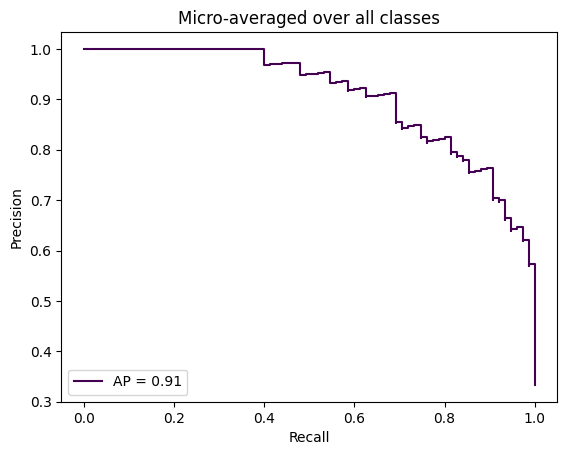

In [74]:
display = PrecisionRecallDisplay(
    recall=recall["micro"],
    precision=precision["micro"],
    average_precision=average_precision["micro"],
)
display.plot()
_ = display.ax_.set_title("Micro-averaged over all classes")

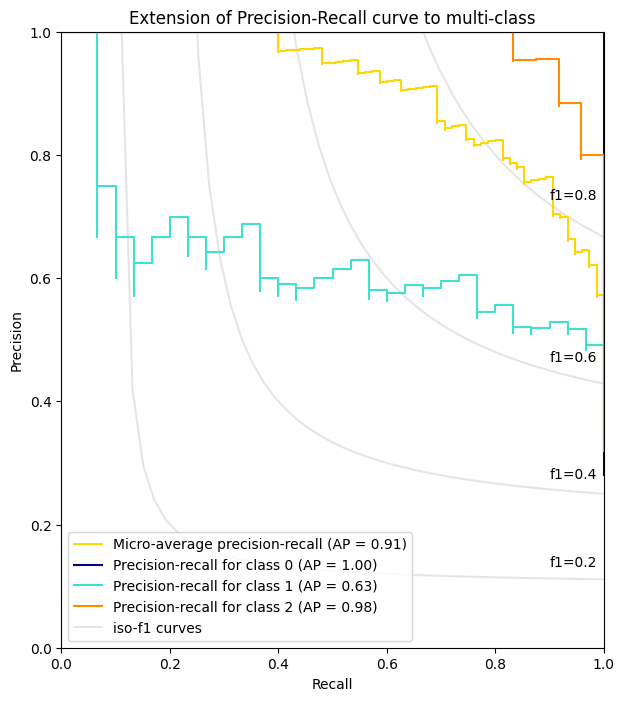

In [75]:
from itertools import cycle

import matplotlib.pyplot as plt

# setup plot details
colors = cycle(["navy", "turquoise", "darkorange", "cornflowerblue", "teal"])

_, ax = plt.subplots(figsize=(7, 8))

f_scores = np.linspace(0.2, 0.8, num=4)
lines, labels = [], []
for f_score in f_scores:
    x = np.linspace(0.01, 1)
    y = f_score * x / (2 * x - f_score)
    (l,) = plt.plot(x[y >= 0], y[y >= 0], color="gray", alpha=0.2)
    plt.annotate("f1={0:0.1f}".format(f_score), xy=(0.9, y[45] + 0.02))

display = PrecisionRecallDisplay(
    recall=recall["micro"],
    precision=precision["micro"],
    average_precision=average_precision["micro"],
)
display.plot(ax=ax, name="Micro-average precision-recall", color="gold")

for i, color in zip(range(n_classes), colors):
    display = PrecisionRecallDisplay(
        recall=recall[i],
        precision=precision[i],
        average_precision=average_precision[i],
    )
    display.plot(ax=ax, name=f"Precision-recall for class {i}", color=color)

# add the legend for the iso-f1 curves
handles, labels = display.ax_.get_legend_handles_labels()
handles.extend([l])
labels.extend(["iso-f1 curves"])
# set the legend and the axes
ax.legend(handles=handles, labels=labels, loc="best")
ax.set_title("Extension of Precision-Recall curve to multi-class")

plt.ylim([0, 1])
plt.xlim([0, 1])
plt.show()

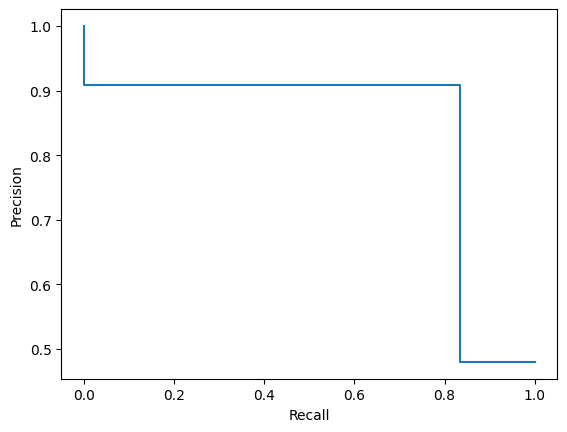

In [196]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.metrics import (precision_recall_curve,
                             PrecisionRecallDisplay)
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
X, y = make_classification(random_state=0)
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    random_state=0)
clf = SVC(random_state=0)
clf.fit(X_train, y_train)
predictions = clf.predict(X_test)
precision, recall, _ = precision_recall_curve(y_test, predictions)
disp = PrecisionRecallDisplay(precision=precision, recall=recall)
disp.plot()

plt.show()

In [197]:
precision, recall

(array([0.48      , 0.90909091, 1.        ]),
 array([1.        , 0.83333333, 0.        ]))

изучаем, почему iso f1 так криво отображаются и как это вылечить

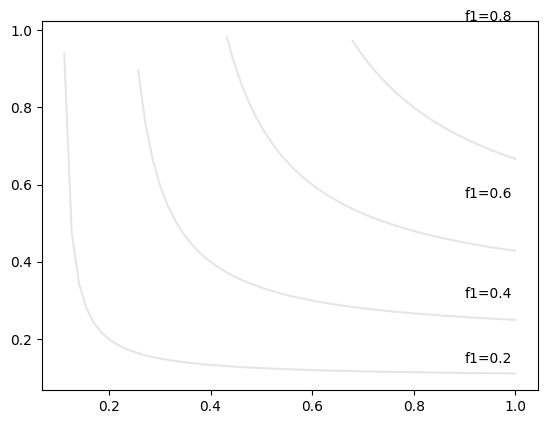

In [502]:
f_scores = np.linspace(0.2, 0.8, num=4)
for f_score in f_scores:
    x = np.linspace(0.01, 1, num=69)
    y = f_score * x / (2 * x - f_score)
    (l,) = plt.plot(x[(y >= 0) & (y <= 1)], y[(y >= 0) & (y <= 1)], color="gray", alpha=0.2)
    plt.annotate("f1={0:0.1f}".format(f_score), xy=(0.9, y[45] + 0.02))

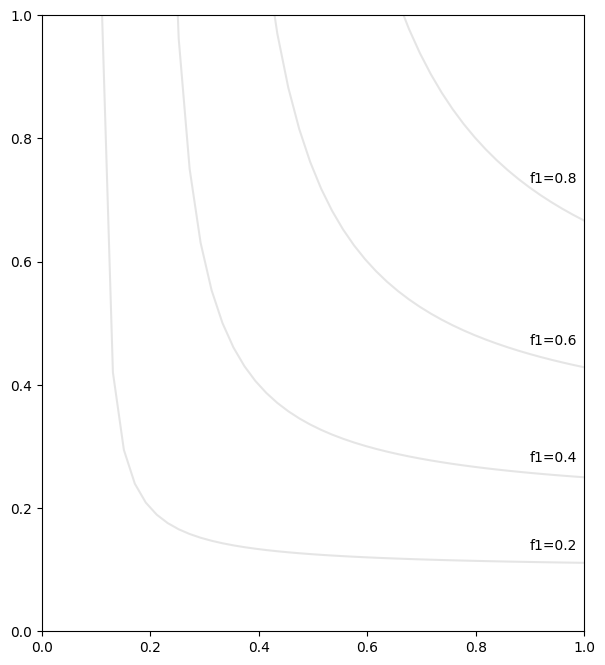

In [40]:
_, ax = plt.subplots(figsize=(7, 8))

f_scores = np.linspace(0.2, 0.8, num=4)
for f_score in f_scores:
    x = np.linspace(0.01, 1)
    y = f_score * x / (2 * x - f_score)
    (l,) = plt.plot(x[y >= 0], y[y >= 0], color="gray", alpha=0.2)
    plt.annotate("f1={0:0.1f}".format(f_score), xy=(0.9, y[45] + 0.02))

plt.ylim([0, 1])
plt.xlim([0, 1])
plt.show()

In [468]:
f_score = 0.2
x = np.linspace(0.01, 1)
y = f_score * x / (2 * x - f_score)

In [473]:
y

array([-0.01111111, -0.04327485, -0.10164609, -0.24027778, -0.98888889,
        1.00740741,  0.42026144,  0.29444444,  0.23960114,  0.20888889,
        0.18925319,  0.17561728,  0.16559572,  0.15791962,  0.15185185,
        0.14693487,  0.14286964,  0.1394525 ,  0.1365399 ,  0.13402778,
        0.13183886,  0.12991453,  0.12820956,  0.12668845,  0.125323  ,
        0.12409046,  0.12297234,  0.12195341,  0.12102102,  0.12016461,
        0.11937525,  0.11864536,  0.11796846,  0.117339  ,  0.11675214,
        0.1162037 ,  0.11569004,  0.11520795,  0.11475459,  0.11432749,
        0.11392441,  0.11354339,  0.11318267,  0.11284067,  0.11251596,
        0.11220727,  0.11191345,  0.11163343,  0.11136627,  0.11111111])

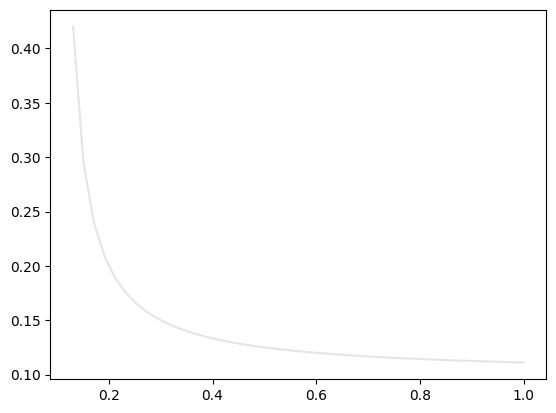

In [469]:
plt.plot(x[(y >= 0) & (y <= 1)], y[(y >= 0) & (y <= 1)], color="gray", alpha=0.2)

In [456]:
x

array([0.01      , 0.03020408, 0.05040816, 0.07061224, 0.09081633,
       0.11102041, 0.13122449, 0.15142857, 0.17163265, 0.19183673,
       0.21204082, 0.2322449 , 0.25244898, 0.27265306, 0.29285714,
       0.31306122, 0.33326531, 0.35346939, 0.37367347, 0.39387755,
       0.41408163, 0.43428571, 0.4544898 , 0.47469388, 0.49489796,
       0.51510204, 0.53530612, 0.5555102 , 0.57571429, 0.59591837,
       0.61612245, 0.63632653, 0.65653061, 0.67673469, 0.69693878,
       0.71714286, 0.73734694, 0.75755102, 0.7777551 , 0.79795918,
       0.81816327, 0.83836735, 0.85857143, 0.87877551, 0.89897959,
       0.91918367, 0.93938776, 0.95959184, 0.97979592, 1.        ])

## Предсказание деревом  
работает по одной фотке за раз

In [21]:
@torch.no_grad()
def inference1(model, img, device):
    model.eval()
    img = img.to(device)
    logits, _ = model(img)
    y_pred = np.argmax(logits.detach().cpu().numpy(), axis=-1)

    return y_pred


def prediction_tree(model_name, data, device):        
    with open(Path.cwd() / "models_tree" / model_name / 'idx2target.json') as fp:
        idx2target = json.load(fp, parse_int=True)
        idx2target = {int(k):v for k,v in idx2target.items()}
        
    NUM_CLASSES=len(idx2target)
    model = Model(
        module_features=pretrain_model.features,
        num_classes=NUM_CLASSES,
    )

    model.load_state_dict(torch.load(Path.cwd() / "models_tree" / model_name / "pytorch_model.bin"))
    y_pred = inference1(model.to(device), data, device)        
    model_name = idx2target[y_pred[0]]
    
    return model_name
    


def predictions(model_name, loader, device):
    y_preds = []
    
    for batch in tqdm(loader):
        data =  batch["img"].to(device)
        model_path = Path.cwd() / "models_tree" / model_name
        y_pred = prediction_tree(model_name, data, device)
#         print(y_pred)
        model_path = Path.cwd() / "models_tree" / y_pred

        while model_path.exists():
            y_pred = prediction_tree(y_pred, data, device)
#             print(y_pred)
            model_path = Path.cwd() / "models_tree" / y_pred
        
        y_preds.append(y_pred)
    
    return y_preds

In [25]:
#dataset_test = WbDataset(test_paths, None, processor)
#dataset_test = WbDataset(test_paths[:8], ytest, processor)
dataset_test = WbDataset(test_paths[:8], None, processor)


test_loader = accelerator.prepare_data_loader(DataLoader(dataset_test,
                                                         batch_size=1,
                                                         shuffle=False,
                                                         pin_memory=True,
                                                         generator=torch.Generator().manual_seed(SEED),
                                                         worker_init_fn=seed_worker)
                                             )

len(dataset_test)

8

In [26]:
y_preds = predictions(model_name, test_loader, device)
y_preds

  0%|          | 0/8 [00:00<?, ?it/s]

['Канцтовары_Бумажная&продукция_Наклейки',
 'Канцтовары_Бумажная&продукция_Книги&и&бланки&для&ведения&учета',
 'Канцтовары_Бумажная&продукция_Наклейки',
 'Канцтовары_Бумажная&продукция_Офисная&бумага',
 'Канцтовары_Бумажная&продукция_Бумага&для&заметок&и&стикеры',
 'Канцтовары_Письменные&принадлежности',
 'Канцтовары_Бумажная&продукция_Расписания&уроков',
 'Канцтовары_Бумажная&продукция_Бумага&для&заметок&и&стикеры']

In [23]:
test_paths[:8]

[WindowsPath('C:/temp/!hse-mlds-project-year2/data/data/Канцтовары_Бумажная&продукция_Наклейки/card/18.png'),
 WindowsPath('C:/temp/!hse-mlds-project-year2/data/data/Канцтовары_Бумажная&продукция_Книги&и&бланки&для&ведения&учета/card/12.png'),
 WindowsPath('C:/temp/!hse-mlds-project-year2/data/data/Канцтовары_Бумажная&продукция_Наклейки/card/16.png'),
 WindowsPath('C:/temp/!hse-mlds-project-year2/data/data/Канцтовары_Бумажная&продукция_Офисная&бумага/card/7.png'),
 WindowsPath('C:/temp/!hse-mlds-project-year2/data/data/Канцтовары_Рисование&и&лепка/card/8.png'),
 WindowsPath('C:/temp/!hse-mlds-project-year2/data/data/Канцтовары_Письменные&принадлежности/card/9.png'),
 WindowsPath('C:/temp/!hse-mlds-project-year2/data/data/Канцтовары_Бумажная&продукция_Расписания&уроков/card/8.png'),
 WindowsPath('C:/temp/!hse-mlds-project-year2/data/data/Канцтовары_Бумажная&продукция_Бумага&для&заметок&и&стикеры/card/10.png')]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


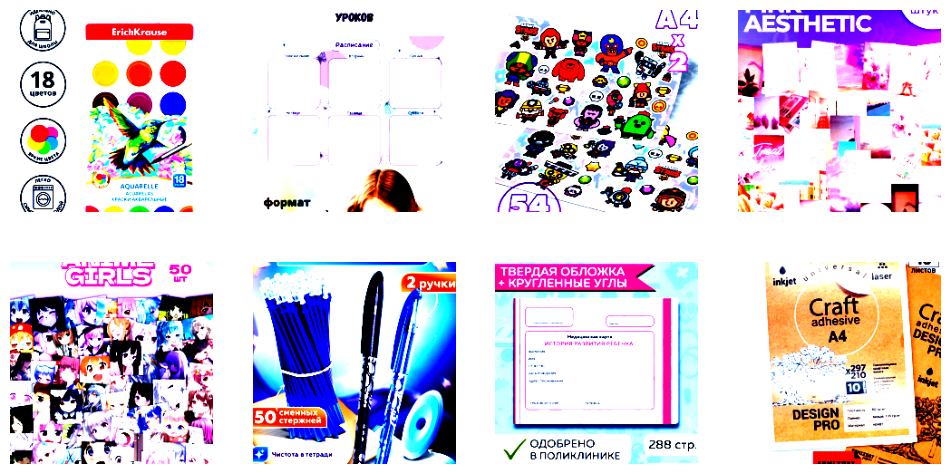

In [24]:
length = len(dataset_test)
indexes = np.random.choice(list(range(length)), size=8, replace=False)

visualise_pics(dataset_test, indexes)